# Setup

In [1]:
import sys
sys.path.insert(1, '/users/genomics/xoel/canonades/bioinforgalician/src/python/celloracle')

In [2]:
import os

subset = 'original'
wdir = f'/users/genomics/xoel/codebases/co_noack/data/{subset}/'
os.makedirs(wdir, exist_ok=True)
os.chdir(wdir)

The history saving thread hit an unexpected error (DatabaseError('database disk image is malformed')).History will not be written to the database.


In [3]:
import scanpy as sc
sc.set_figure_params(
    scanpy=True,
    dpi=80, 
    dpi_save=300, 
    frameon=True,
    vector_friendly=True, 
    fontsize=14, 
    figsize=None, 
    color_map=None,
    facecolor=None, 
    transparent=False, 
    ipython_format='png2x')
sc.settings.verbosity=4
sc.settings.autosave=True
sc.settings.autoshow=True

import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [6, 4.5]
plt.rcParams["savefig.dpi"] = 300

In [4]:
n_cores = min(int(os.getenv('SLURM_CPUS_PER_TASK')) -4 or 18, 96)


# **Part 1 //** Create a gene regulatory network (GRN)

## Find ATAC coaccessible peaks

Since the authors ran Cicero as well to extract the coaccessible peaks (conns and peaks), I leveraged their script to run cicero in the provided ATAC RDS

In [9]:
!cat '../../src/Cicero_connections.r'

library(Signac)
library(Seurat)
library(monocle3)
library(cicero)
library(reticulate)
library(ggplot2)
library(GenomeInfoDb)
library(EnsDb.Mmusculus.v79)
library(TxDb.Mmusculus.UCSC.mm10.knownGene)
library(BSgenome.Mmusculus.UCSC.mm10)
library(org.Mm.eg.db)
library(data.table)
library(plyr)
library(dplyr)
library(ComplexHeatmap)
library(seriation)
library(scales)

# source('scripts/config.R')
source('./Noack_et_al_NatNeuro2021/aux_functions.R')
# fragment.path <- "data/fragments.filtered.gz"
# mm10_txdb <- loadDb("/home/hpc/bonev/annotations/mm10/mm10_txdb.sqlite")

##### Initialize the seurat object ########

# cortex.atac <- readRDS('data/merged_scATAC_integrated.RDS')
atac <- readRDS('./../data/raw/merged_scATAC_integrated_cicero.RDS')
DefaultAssay(atac) <- 'MACS2peaks'

# Subset cell types of interest
atac <- subset(atac, predicted.id %in% c('IPC', 'IPC_M', 'NSC', 'NSC_M', 'PN1', 'PN2', 'PN3'))

# parameters
mdata <- atac@meta.data
tssWindow <- 2500
flank <- 250*10^3
corCutOff <- 0

In [10]:
os.listdir()

['gimme.vertebrate.v5.0.pfm',
 'MotifObject.pkl',
 'gimme.vertebrate.v5.0.motif2factors.txt']

This will execute the script to extract the connections with the appropriate genome and settings. Takes a while.

In [6]:
%%bash
eval "$(micromamba shell hook --shell=bash)"
micromamba activate ~/venvs/cicero
Rscript --vanilla --verbose ../src/Cicero_connections.r > cicero.log 2>&1

In [ ]:
# !while [ 1 ]; do tail log.test.txt; sleep 30; clear; done
!cat cicero.log # | grep -v 'chr1' |  tail -20

cat: log.test.txt: No such file or directory


## Run motif analysis and filter

In [11]:
import cicero_to_grn 

Adding to PATH: /soft/system/software/BEDTools/2.30.0-GCC-10.2.0/bin


In [13]:
import pickle as pkl

In [15]:
with open('MotifObject.pkl', 'rb') as f:
    motifs = pkl.load(f)

In [18]:
grn_result = cicero_to_grn.run_motif_analysis(
    peaks_csv='../cicero_peaks.csv',
    connections_csv='../cicero_conns.csv',
    extra_peaks=None,
    ref_genome='mm10',
    provider='UCSC',
    frp=0.02,
    coacc_thres=0.8,
    motifs=motifs,
    motif_score_thres=8,
    save_dir='./',
    prefix=None,
    verbose=True
)

[1] Loading peaks and connections
[2] Loading genome
genome mm10 is not installed in this environment.
Please install genome using genomepy.
e.g.
    >>> import genomepy
    >>> genomepy.install_genome(name="mm10", provider="UCSC")
Genome mm10 is not installed. Installing.


09:43:09 | INFO | Downloading assembly summaries from UCSC
09:43:19 | INFO | Downloading genome from UCSC. Target URL: http://hgdownload.soe.ucsc.edu/goldenPath/mm10/bigZips/chromFa.tar.gz...


Download:   0%|          | 0.00/830M [00:00<?, ?B/s]

10:00:57 | INFO | Genome download successful, starting post processing...
10:02:32 | INFO | name: mm10
10:02:32 | INFO | local name: mm10
10:02:32 | INFO | fasta: /users/genomics/xoel/.local/share/genomes/mm10/mm10.fa


Filtering Fasta: 0.00 lines [00:00, ? lines/s]

[3] Integrating peaks, connections and genome
que bed peaks: 370974
tss peaks in que: 31607
[4] Filtering peaks by coaccessibility (0.8)
Over threshold: 1.66 %
[5] Extracting peaks
[6] Performing motif scan (frp: 0.02)
Checking your motifs... Motifs format looks good. 

Initiating scanner... 

Calculating FPR-based threshold. This step may take substantial time when you load a new ref-genome. It will be done quicker on the second time. 



2023-04-27 10:05:16,821 - INFO - determining FPR-based threshold


Motif scan started .. It may take long time.



scanning:   0%|          | 0/29010 [00:00<?, ? sequences/s]

[7] Filtering motif score (motif_score_thres)
Over threshold: 44.14 %
Filtering finished: 7959632 -> 2894805
1. Converting scanned results into one-hot encoded dataframe.


  0%|          | 0/29010 [00:00<?, ?it/s]

2. Converting results into dictionaries.


  0%|          | 0/16538 [00:00<?, ?it/s]

  0%|          | 0/1714 [00:00<?, ?it/s]

[8] Saving results


  0%|          | 0/3 [00:00<?, ?it/s]

#### Check if Neurod2 is there

In [6]:
import celloracle as co

In [7]:
tfi=co.load_hdf5('celloracle_tfinfo.coaccessibility=0.8.score=8.celloracle.tfinfo')

In [15]:
'Neurod2'.upper() in [c.upper() for c in tfi.all_target_gene]

True

In [16]:
[k for k, v in tfi.dic_motif2TFs.items() if 'Neurod2'.upper() in [c.upper() for c in v]]

['GM.5.0.bHLH.0006',
 'GM.5.0.bHLH.0007',
 'GM.5.0.bHLH.0010',
 'GM.5.0.bHLH.0036',
 'GM.5.0.bHLH.0042',
 'GM.5.0.bHLH.0045',
 'GM.5.0.bHLH.0063',
 'GM.5.0.bHLH.0121']

In [17]:
[k for k, v in tfi.dic_targetgene2TFs.items() if 'Neurod2'.upper() in [c.upper() for c in v]]

['Rassf9',
 'Ccdc59',
 'Ppfia2',
 'Lin7a',
 'Myf5',
 'Nav3',
 'E2f7',
 'Csrp2',
 'Bbs10',
 'Nap1l1',
 'Kcnc2',
 'Fbxo30',
 'Tph2',
 'Thap2',
 'Zfc3h1',
 'A930009A15Rik',
 '4930579P08Rik',
 'Best3',
 'Frs2',
 'Yeats4',
 'Cpm',
 'Mdm2',
 'Nup107',
 'Mdm1',
 'Grip1',
 'Grip1os2',
 'Tmbim4',
 'Llph',
 '9230105E05Rik',
 'Lemd3',
 'Wif1',
 '4930432O09Rik',
 'D930020B18Rik',
 'BC048403',
 'A130077B15Rik',
 'Ppm1h',
 'Mon2',
 'Usp15',
 'Mir546',
 'Tsfm',
 'Mettl21b',
 'March9',
 'Cdk4',
 'Os9',
 'Pip4k2c',
 'Kif5a',
 'Dctn2',
 'Mbd6',
 'Arhgap9',
 'Gli1',
 'R3hdm2',
 'Shmt2',
 'Gpr182',
 'Rdh16',
 'Ptges3',
 'Baz2a',
 'Timeless',
 'Il23a',
 'Cs',
 'Myl6',
 'Myl6b',
 'Gm26876',
 'Dgka',
 'Gdf11',
 'Rdh5',
 'B230208H11Rik',
 'Plagl1',
 'Phactr2',
 'Aig1',
 'Gm20125',
 'Reps1',
 'Ect2l',
 'Ccdc28a',
 'Gm32926',
 'Arfgef3',
 'Olig3',
 'Ifngr1',
 'Slc35d3',
 'Map3k5',
 'Map7',
 '4930405J17Rik',
 'Pde7b',
 '4930455C13Rik',
 'Sgk1',
 'E030030I06Rik',
 'C920009B18Rik',
 'Mir7663',
 'Tcf21',
 'Eya4',
 

In [18]:
'Neurod2'.upper() in [c.upper() for c in tfi.dic_TF2targetgenes.keys()]

True

In [19]:
tfi.scanned_df.motif_id.str.contains('study').sum()

0

In [20]:
tfi.scanned_df['factors_direct'].str.upper().str.contains('Neurod2'.upper()).sum()

3522

In [21]:
tfi.scanned_df['factors_indirect'].str.upper().str.contains('Neurod2'.upper()).sum()

11577

In [22]:
tfi.easy_log

time                               info
0  Thu Apr 27 10:05:07 2023                         initiation
1  Thu Apr 27 10:25:36 2023                         scanMotifs
2  Thu Apr 27 10:25:40 2023  thresholdingByAcumulatedBindScore
3  Thu Apr 27 10:27:15 2023                makeOnehotDataframe
4  Thu Apr 27 10:33:31 2023                  make_dictionaries

In [26]:
[k for k, v in tfi.dic_motif2TFs.items() if 'Neurod2' in v]

['GM.5.0.bHLH.0006',
 'GM.5.0.bHLH.0007',
 'GM.5.0.bHLH.0010',
 'GM.5.0.bHLH.0036',
 'GM.5.0.bHLH.0042',
 'GM.5.0.bHLH.0045',
 'GM.5.0.bHLH.0063',
 'GM.5.0.bHLH.0121']

In [31]:
tfi.scanned_filtered[tfi.scanned_filtered.motif_id.isin([k for k, v in tfi.dic_motif2TFs.items() if 'Neurod2' in v])]['motif_id'].unique()

array(['GM.5.0.bHLH.0042', 'GM.5.0.bHLH.0045', 'GM.5.0.bHLH.0063',
       'GM.5.0.bHLH.0006', 'GM.5.0.bHLH.0007', 'GM.5.0.bHLH.0036',
       'GM.5.0.bHLH.0010', 'GM.5.0.bHLH.0121'], dtype=object)

# **Part 2 //** Prepare RNA data

In [5]:
import scanpy as sc
import prepare_rna
%matplotlib inline

In [6]:
sorted(os.listdir())

['.ipynb_checkpoints',
 'ATAC.cell_metadata.tsv',
 'ATAC.peak_metadata.tsv',
 'ATAC.unprocessed.tsv',
 'Gradient.Perturbation.celloracle.gradient',
 'Links.Perturbation.celloracle.links',
 'Links.celloracle.links',
 'Oracle.Perturbation.celloracle.oracle',
 'Oracle.celloracle.oracle',
 'RNA.processed.h5ad',
 'RNA.unprocessed.h5ad',
 'RootCellSelection.html',
 'Rplots.pdf',
 'base_grn.coaccessibility=0.8.score=8.base_grn.parquet',
 'celloracle_tfinfo.coaccessibility=0.8.score=8.celloracle.tfinfo',
 'cicero.log',
 'cicero_connections.csv',
 'cicero_connections.rds',
 'cicero_peaks.csv',
 'cicero_umap.pdf',
 'cluster_GRN',
 'coaccessible_peaks.coaccessibility=0.8.csv',
 'figures',
 'network_plots',
 'perturbations',
 'perturbations.wrong p.mass']

In [63]:
palette = {
    'NSC': '#F51111',
    'NSC_M': '#FFCAC7',
    'IPC': '#16A810',
    'IPC_M': '#D6FFD1',
    'PN1': '#EBEB17',
    'PN2': '#4861F0',
    'PN3': '#F20DFA',
    'CR': '#16EAF5',
    'IN': '#7400D9',
    'MG': '#9E560E',
    'Mural': '#FFA200'
}

In [79]:
adata_file = '../../raw/xabier/merged_scRNA_unfiltered_IDs.selected_celltypes.h5ad'
adata_complete = sc.read_h5ad(adata_file)

In [82]:
# adata_complete.uns['neighbors_authors'] = adata_complete.uns['neighbors']
# adata_complete.obsp['distances_authors'] = adata_complete.obsp['distances']

In [83]:
adata_complete.layers['scaled'] = adata_complete.X

adata_complete.layers['raw'] = adata_complete.layers['counts']
adata_complete.X = adata_complete.layers['counts']

adata_complete.layers['lognorm'] = adata_complete.raw.X

In [84]:
adata_complete.obs['annotation'] = pd.Categorical(adata_complete.obs['annotation'], adata_complete.obs.sort_values(by='annotation_id')['annotation'].unique())

adata_complete.uns['annotation_colors'] = [palette[k] for k in adata_complete.obs['annotation'].cat.categories]

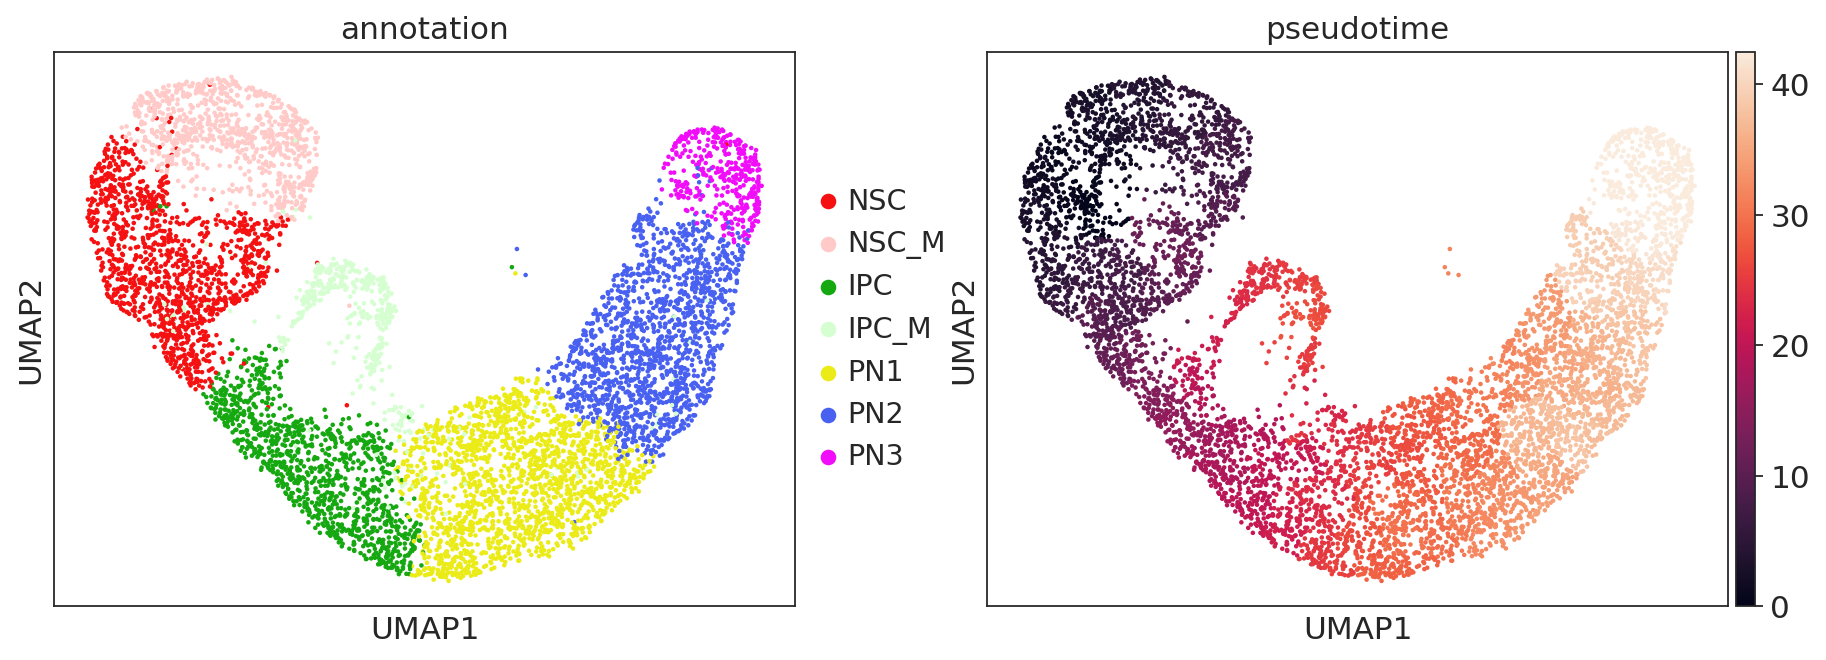

In [85]:
sc.pl.umap(adata_complete, color=['annotation', 'pseudotime'])

In [86]:
root_cell = adata_complete.obs.sort_values('pseudotime').index[0]

### PIPE [1] PREPROCESSING DATA


  0%|          | 0/8 [00:00<?, ?it/s]

[1] Saving raw counts
[2] Computing QC
[3] Filtering genes: total_counts > 1
[4] Normalizing per cell using nCount_RNA
normalizing by total count per cell
    finished (0:00:05): normalized adata.X and added    'nCount_RNA', counts per cell before normalization (adata.obs)
[5] Computing highly variable genes and filtering to top 3000
(7207, 17633)
extracting highly variable genes
    the 3000 top genes correspond to a normalized dispersion cutoff of 1.7636183500289917
    finished (0:00:00)


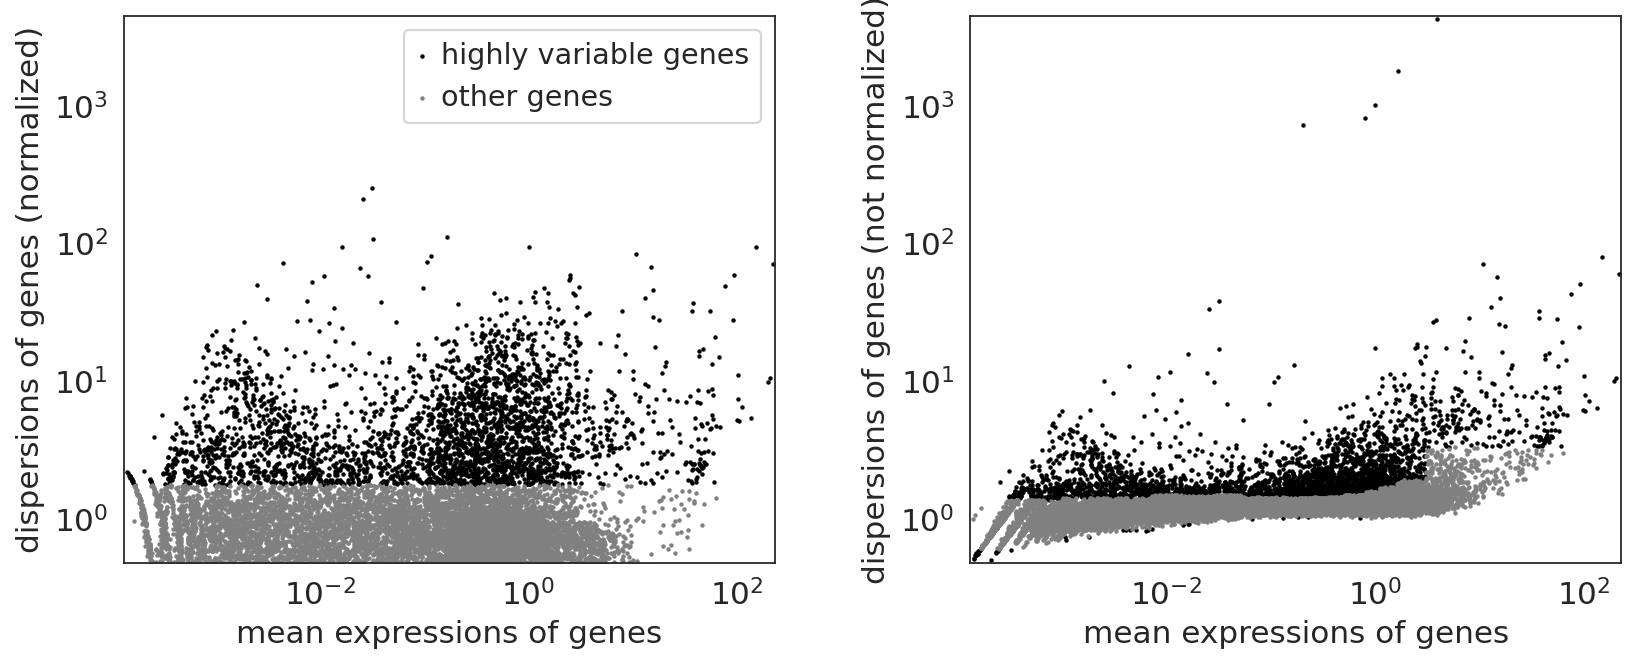

(7207, 2999)
[6] Normalizing per cell again using nCount_RNA
normalizing by total count per cell
    finished (0:00:01): normalized adata.X and added    'nCount_RNA', counts per cell before normalization (adata.obs)
[7] Log1p transformation
[8] Scaling
... as `zero_center=True`, sparse input is densified and may lead to large memory consumption
### PIPE [2] EMBEDDING DATA


  0%|          | 0/8 [00:00<?, ?it/s]

[1] Computing PCA
computing PCA
    with n_comps=50
    finished (0:00:00)
    and added
    'X_pca', the PCA coordinates (adata.obs)
    'PC1', 'PC2', ..., the loadings (adata.var)
    'pca_variance', the variance / eigenvalues (adata.uns)
    'pca_variance_ratio', the variance ratio (adata.uns)


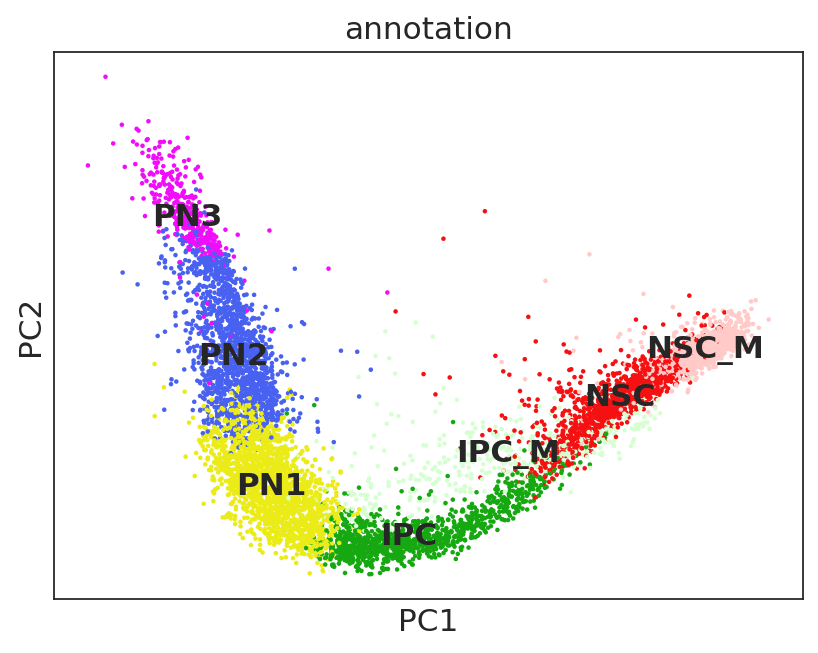

[2] Computing neighbors
computing neighbors
    computing neighbors
    computed neighbors (0:00:01)
    computed connectivities (0:00:00)
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:01)
[3] Computing diffusion map
computing Diffusion Maps using n_comps=30(=n_dcs)
        initialized `.distances` `.connectivities` 
computing transitions
    finished (0:00:00)
    eigenvalues of transition matrix
    [1.         0.99854696 0.9970546  0.9942384  0.9921033  0.9903335
     0.98891413 0.9876905  0.98483163 0.9794231  0.97440636 0.9732072
     0.9723396  0.96901    0.96750236 0.9643201  0.9610518  0.9598193
     0.9576831  0.95702857 0.95406103 0.951941   0.9483089  0.94545025
     0.94228506 0.9410508  0.93796104 0.9362672  0.9355332  0.9315927 ]
    finished: added
    'X_diffmap', diffmap coordinates (adata.obsm)
    'diffmap_evals', eigenvalues of transition matrix

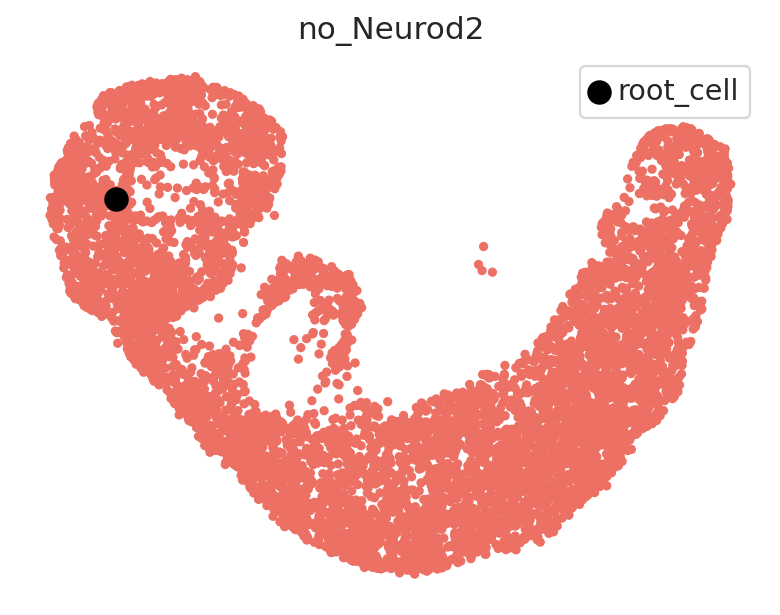

        initialized `.distances` `.connectivities` `.eigen_values` `.eigen_basis` `.distances_dpt`
computing Diffusion Pseudotime using n_dcs=10
    finished: added
    'dpt_pseudotime', the pseudotime (adata.obs) (0:00:00)


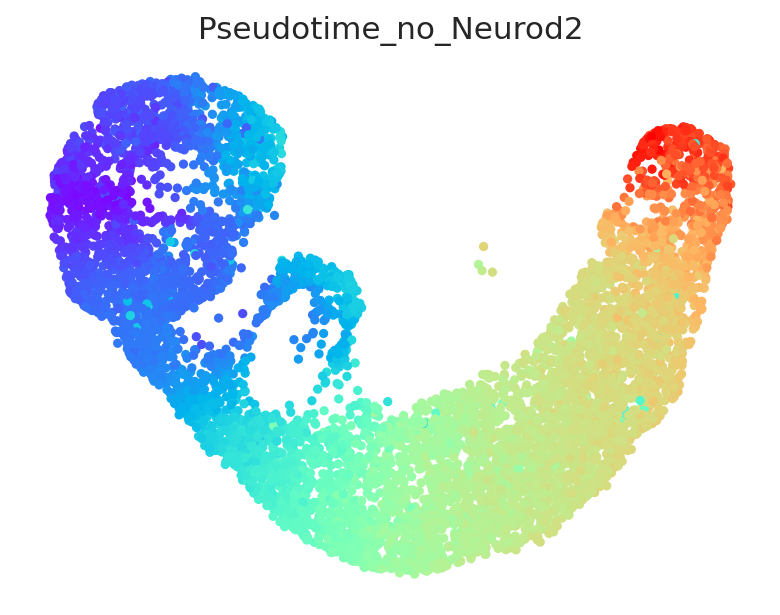

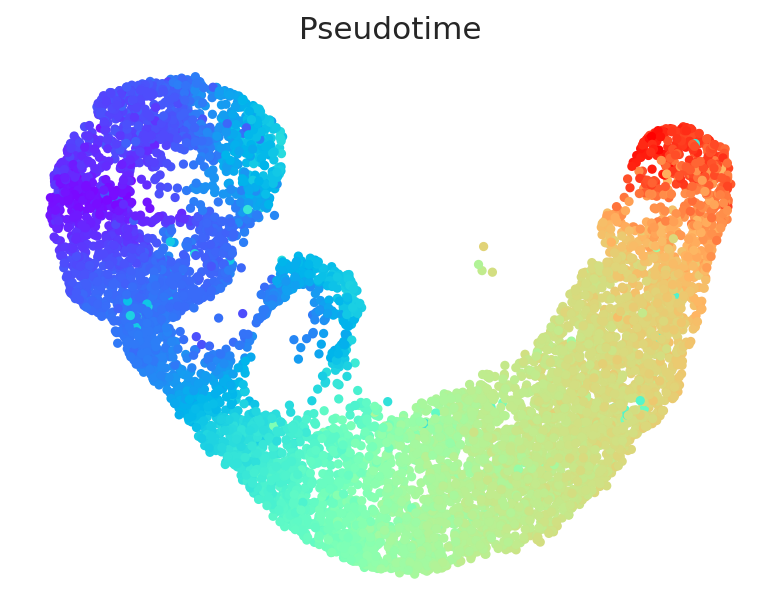

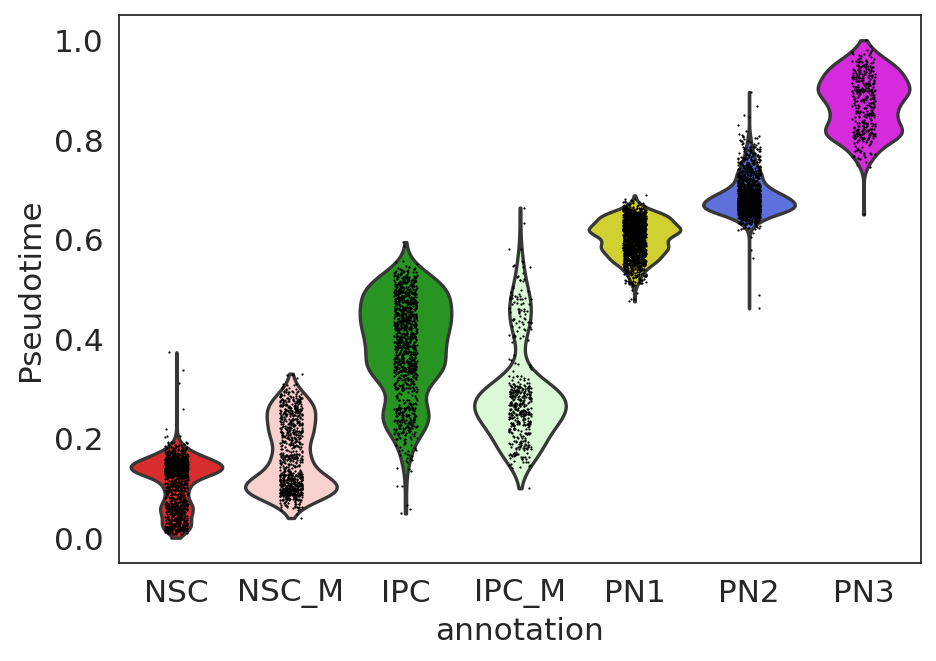

### PIPE [4] SAVING DATA


In [95]:
adata = prepare_rna.prepare_adata(
    
    adata_complete,
    group_by='annotation',
    save_dir='./../',
    
    min_total_counts_per_cell=1,
    key_n_counts='nCount_RNA',
    n_top_genes=3000,

    # prefix='test',

    nn_1_n_neighbors=20,
    nn_1_use_rep='X_harmony',
    nn_1_n_pcs=10,
    dm_n_comps=30,
    nn_2_n_neighbors=100,

    phate_run_on='X',
    phate_knn=100, 
    phate_n_pca=50, 
    phate_decay=15, 
    phate_t='auto',
    
    skip_umap=True,
    skip_paga=True,
    skip_phate=True,
    random_state=None,    

    root_cells=root_cell,
    lineages=None, 
    lineage_name=subset,
    embedding_key='X_umap',

    verbose=True)

# **Part 3 //** Fit GRN to expression

In [5]:
import network_fit

In [6]:
sorted(os.listdir())

['MotifObject.pkl',
 'base_grn.coaccessibility=0.8.score=8.base_grn.parquet',
 'celloracle_tfinfo.coaccessibility=0.8.score=8.celloracle.tfinfo',
 'coaccessible_peaks.coaccessibility=0.8.csv',
 'gimme.vertebrate.v5.0.motif2factors.txt',
 'gimme.vertebrate.v5.0.pfm']

In [7]:
import scanpy as sc
import pandas as pd

In [8]:
adata = sc.read_h5ad('../RNA.processed.h5ad', backed=True)

In [10]:
pd.DataFrame(adata.layers['raw_count'].sum(1)).describe()

0
count   7207.000000
mean    7654.943388
std     2800.175122
min     1049.000000
25%     5699.000000
50%     7309.000000
75%     9272.500000
max    22861.000000

In [13]:
oracle, links = network_fit.network_fit_pipe(
    adata_fname = '../RNA.processed.h5ad',
    base_GRN_fname = 'base_grn.coaccessibility=0.8.score=8.base_grn.parquet',
    cluster_column_name = 'annotation',
    max_n_pcs = 50,
    links_alpha=10,
    
    embedding_name='X_umap',
    
    tempdir=f'/scratch/{subset}/tmp/',
    
    links_pval=0.001,
    links_top_n_coef=2000,
    seed = 4,
    verbose = True,
    save_dir='./',
    test_mode=False)

  0%|          | 0/7 [00:00<?, ?it/s]

[1] Reading data
Loading adata
Loading GRN
[2] Prepairing oracle object


  0%|          | 0/4 [00:00<?, ?it/s]

[1] Instatiating Oracle with raw RNA-Seq data
    Expression range:                   0
count   7207.000000
mean    7654.943388
std     2800.175122
min     1049.000000
25%     5699.000000
50%     7309.000000
75%     9272.500000
max    22861.000000
[2] Adding GRN data to Oracle
[3] Computing and selecting PCs and k for neighbors
[4] Computing KNNs:
    n cells: 7207
    k: 180
    oracle.knn_imputation(n_pca_dims=n_comps, k=180, balanced=True, b_sight=1440, b_maxl=720, n_jobs=-1)
Oracle object

Meta data
    celloracle version used for instantiation: 0.12.0
    n_cells: 7207
    n_genes: 2999
    cluster_name: annotation
    dimensional_reduction_name: X_umap
    n_target_genes_in_TFdict: 16538 genes
    n_regulatory_in_TFdict: 1714 genes
    n_regulatory_in_both_TFdict_and_scRNA-seq: 162 genes
    n_target_genes_both_TFdict_and_scRNA-seq: 2405 genes
    k_for_knn_imputation: 180
Status
    Gene expression matrix: Ready
    BaseGRN: Ready
    PCA calculation: Done
    Knn imputation: Do

  0%|          | 0/7 [00:00<?, ?it/s]

Inferring GRN for IPC...


  0%|          | 0/2405 [00:00<?, ?it/s]

Inferring GRN for IPC_M...


  0%|          | 0/2405 [00:00<?, ?it/s]

Inferring GRN for NSC...


  0%|          | 0/2405 [00:00<?, ?it/s]

Inferring GRN for NSC_M...


  0%|          | 0/2405 [00:00<?, ?it/s]

Inferring GRN for PN1...


  0%|          | 0/2405 [00:00<?, ?it/s]

Inferring GRN for PN2...


  0%|          | 0/2405 [00:00<?, ?it/s]

Inferring GRN for PN3...


  0%|          | 0/2405 [00:00<?, ?it/s]

[4] Checking links
All fits are valid.
[5] Postprocessing links
[6] Scoring genes


  0%|          | 0/7 [00:00<?, ?it/s]

/scratch/original/tmp/47/57
/scratch/original/tmp/47/32
/scratch/original/tmp/47/99
/scratch/original/tmp/47/64
/scratch/original/tmp/47/31/scratch/original/tmp/47/37

/scratch/original/tmp/47/17
/users/genomics/xoel/venvs/cicero/bin/R
/users/genomics/xoel/venvs/cicero/bin/R
/users/genomics/xoel/venvs/cicero/bin/R
/users/genomics/xoel/venvs/cicero/bin/R
/users/genomics/xoel/venvs/cicero/bin/R
/users/genomics/xoel/venvs/cicero/bin/R
/users/genomics/xoel/venvs/cicero/bin/R



Attaching package: ‘igraph’

The following objects are masked from ‘package:stats’:

    decompose, spectrum

The following object is masked from ‘package:base’:

    union


Attaching package: ‘igraph’

The following objects are masked from ‘package:stats’:

    decompose, spectrum

The following object is masked from ‘package:base’:

    union


Attaching package: ‘igraph’

The following objects are masked from ‘package:stats’:

    decompose, spectrum

The following object is masked from ‘package:base’:

    union


Attaching package: ‘igraph’

The following objects are masked from ‘package:stats’:

    decompose, spectrum

The following object is masked from ‘package:base’:

    union


Attaching package: ‘igraph’

The following objects are masked from ‘package:stats’:

    decompose, spectrum

The following object is masked from ‘package:base’:

    union


Attaching package: ‘igraph’

The following objects are masked from ‘package:stats’:

    decompose, spectrum

The following 

[7] Saving results
- Saving raw links per cluster


  0%|          | 0/7 [00:00<?, ?it/s]

- Saving filtered links per cluster


  0%|          | 0/7 [00:00<?, ?it/s]

- Saving processed links
- Saving oracle


In [14]:
%matplotlib Agg
network_fit.pipe_plots(links)

  0%|          | 0/5 [00:00<?, ?it/s]

IPC
IPC_M
NSC
NSC_M
PN1
PN2
PN3


  0%|          | 0/7 [00:00<?, ?it/s]

degree_centrality_all
eigenvector_centrality


  0%|          | 0/3 [00:00<?, ?it/s]

Genes in filtered network: 1278


  0%|          | 0/1278 [00:00<?, ?it/s]

0610010F05Rik
1190002N15Rik
1700025G04Rik
1810037I17Rik
2810459M11Rik
2900009J06Rik
2900011O08Rik
4930402H24Rik
6330403K07Rik
9330159F19Rik
A930024E05Rik
AI504432
AI593442
Abcd2
Abracl
Acads
Ackr3
Acot1
Acss1
Actb
Actl6b
Actn1
Actr3b
Adamts1
Adamts18
Add2
Adgrb3
Adgrl1
Adgrl2
Adra2c
Afap1
Aff3
Agap3
Ago1
Aig1
Ajuba
Akap6
Akr1b3
Alcam
Aldoa
Aldoc
Alkbh2
Amotl2
Ank3
Ankrd12
Ankrd26
Anln
Ano8
Anp32b
Ap3b2
Apba2
Apc
Apc2
Aplp1
Arfgef3
Arhgap11a
Arhgap19
Arhgap20
Arid5b
Arl4c
Arl6ip1
Arl6ip5
Arx
Ascl1
Aspm
Asrgl1
Asxl3
Atad2
Atad5
Atf3
Atl1
Atp1a2
Atp1a3
Atp2b1
Atpif1
Aunip
Aurka
Aurkb
Auts2
B3galt1
B3gat1
B3gat2
Bach2
Baiap2
Basp1
Batf3
Baz1a
Baz1b
Baz2b
Bcar1
Bcl11a
Bcl11b
Bcl2
Bdh1
Bend5
Bhlhe22
Bicd1
Birc5
Bmp3
Bok
Bora
Brca1
Brinp1
Brinp2
Btbd17
Btg2
Bub1
Bub1b
Bub3
Bzw2
C1qtnf4
C330027C09Rik
Cabp1
Cacna1e
Cacna2d1
Cacng4
Cadm1
Cadm2
Cadps
Cald1
Calm1
Calm2
Caly
Camk2b
Camk2n1
Camk2n2
Camk4
Camkk2
Camkv
Carmil3
Casp8ap2
Cbfa2t2
Ccdc136
Ccdc18
Ccdc34
Cck
Ccna2
Ccnb1
Ccnb2
Ccnd1
Ccnd2
Cc

  0%|          | 0/1278 [00:00<?, ?it/s]

()

# **Part 4 //** Perturbation analysis

In [5]:
import perturbations

In [6]:
sorted(os.listdir())

['Links.celloracle.links',
 'MotifObject.pkl',
 'Oracle.celloracle.oracle',
 'base_grn.coaccessibility=0.8.score=8.base_grn.parquet',
 'celloracle_tfinfo.coaccessibility=0.8.score=8.celloracle.tfinfo',
 'cluster_GRN',
 'coaccessible_peaks.coaccessibility=0.8.csv',
 'gimme.vertebrate.v5.0.motif2factors.txt',
 'gimme.vertebrate.v5.0.pfm',
 'network_plots']

In [9]:
knn = 180
knn

180

  0%|          | 0/6 [00:00<?, ?it/s]

[1] Loading data
[2] Re-filtering links
[3] Getting TF dict
[4] Fitting for simulation


  0%|          | 0/7 [00:00<?, ?it/s]

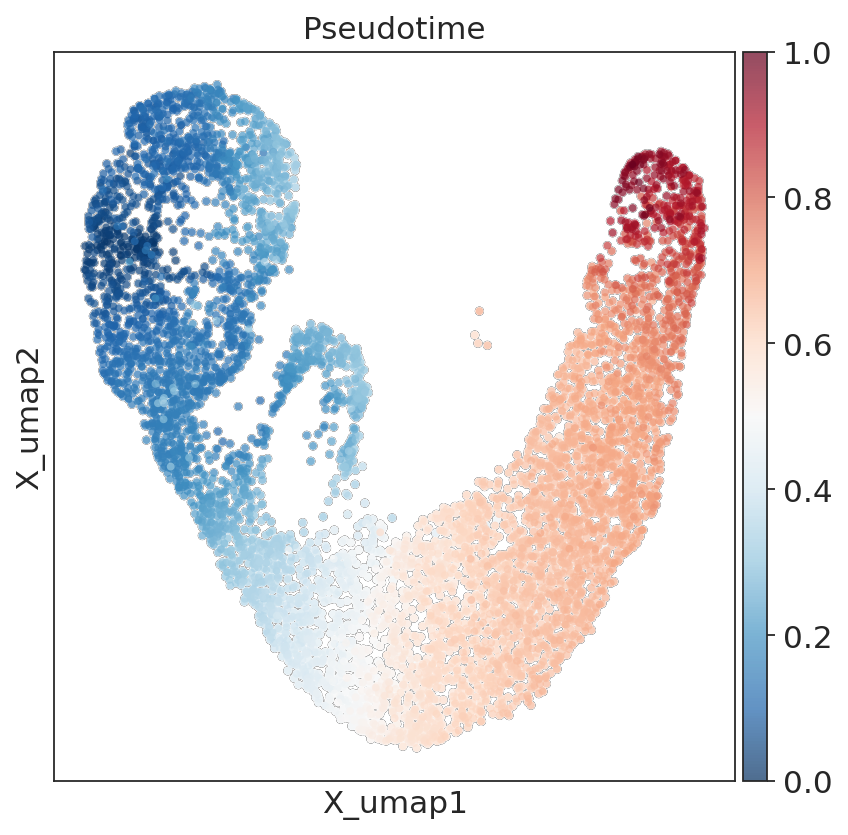

[5] Computing grid p_mass
[6] Transferring pseudotime to grid
KNN pseudotime-transfer model


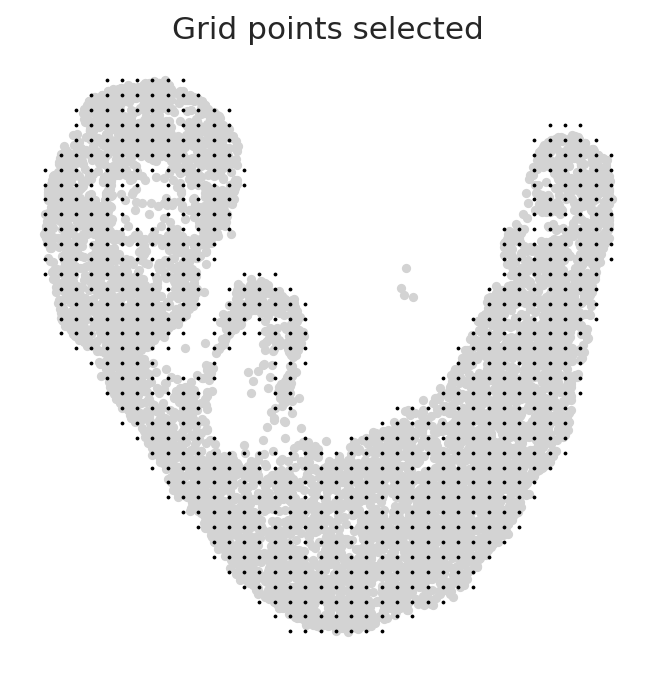

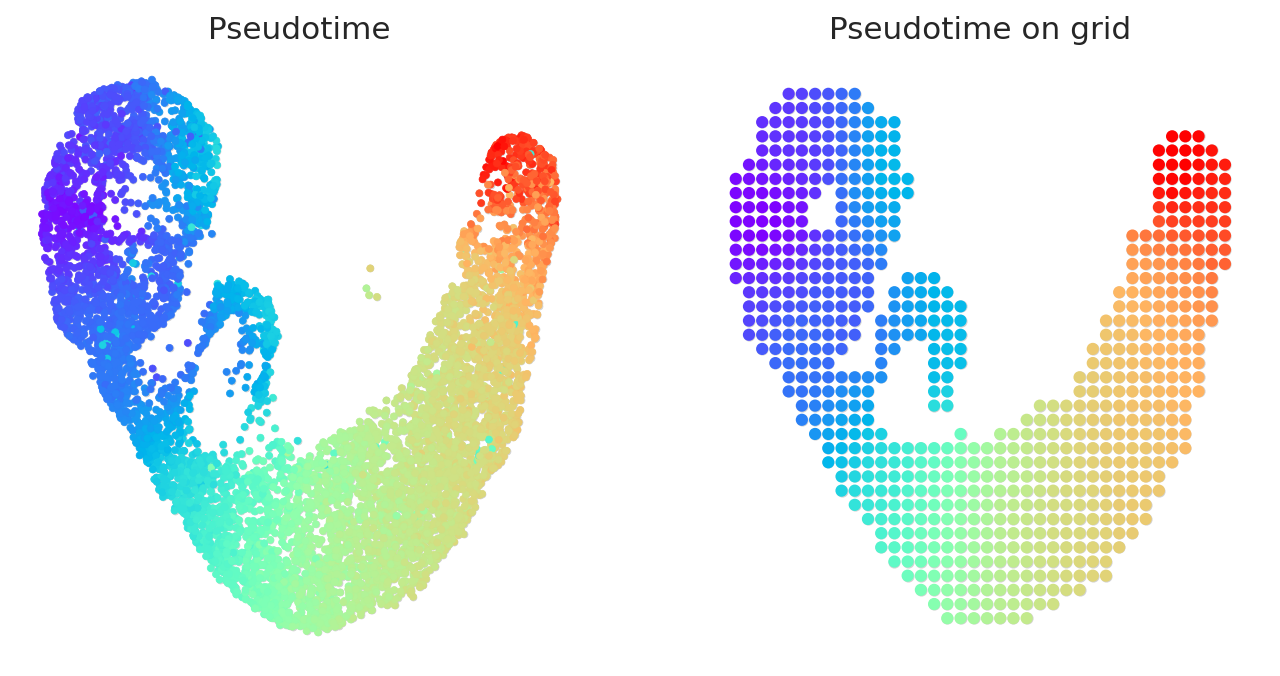

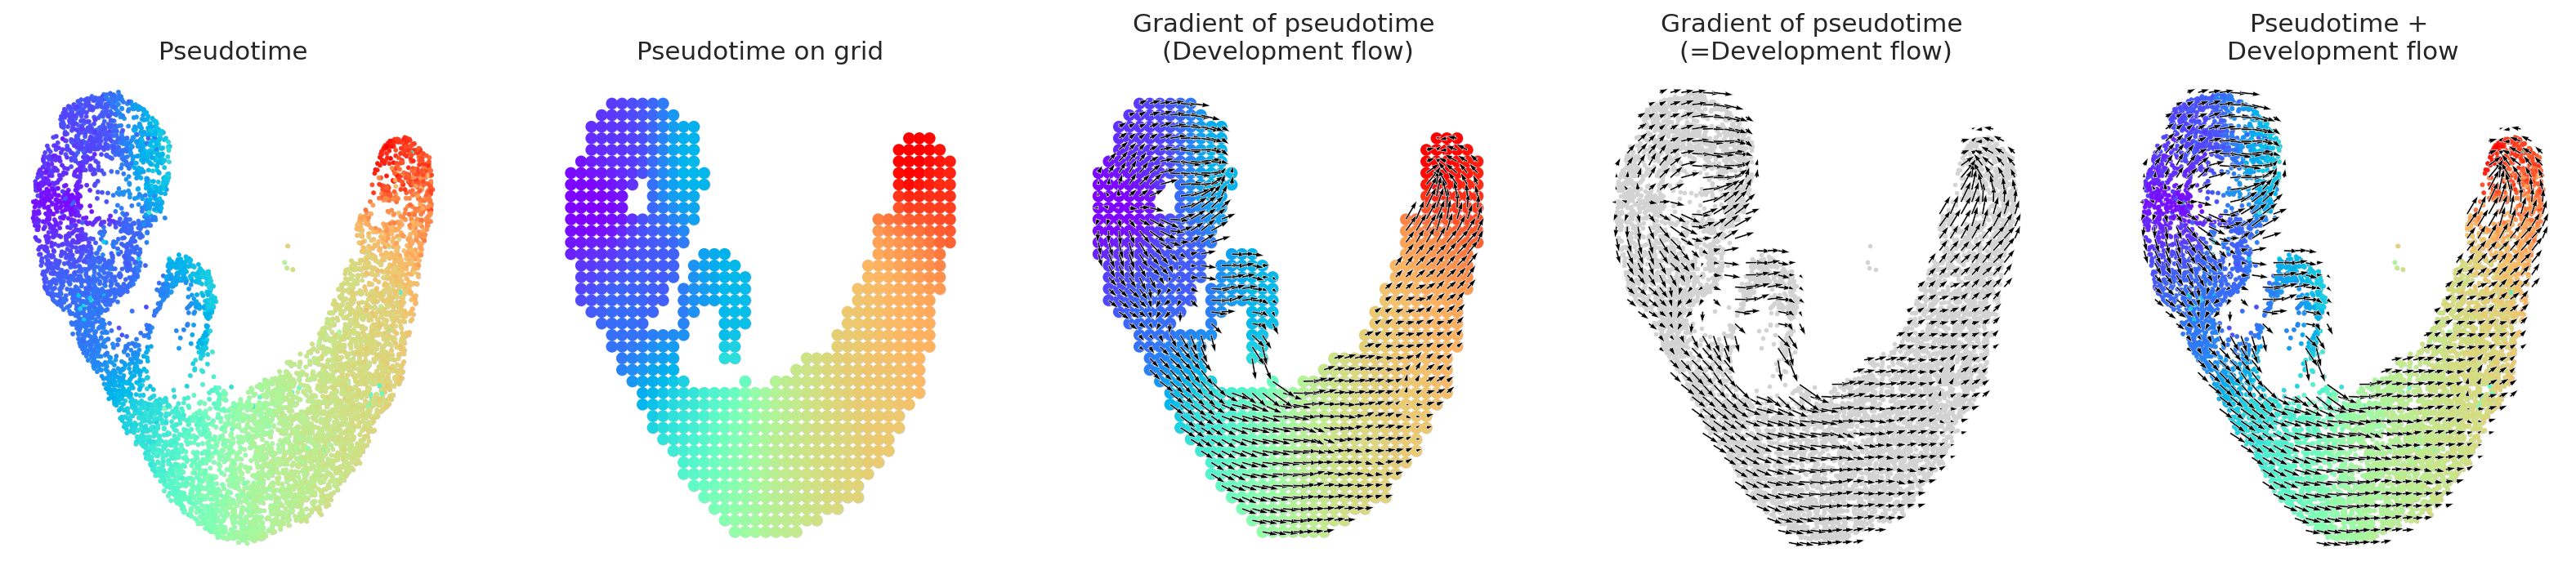

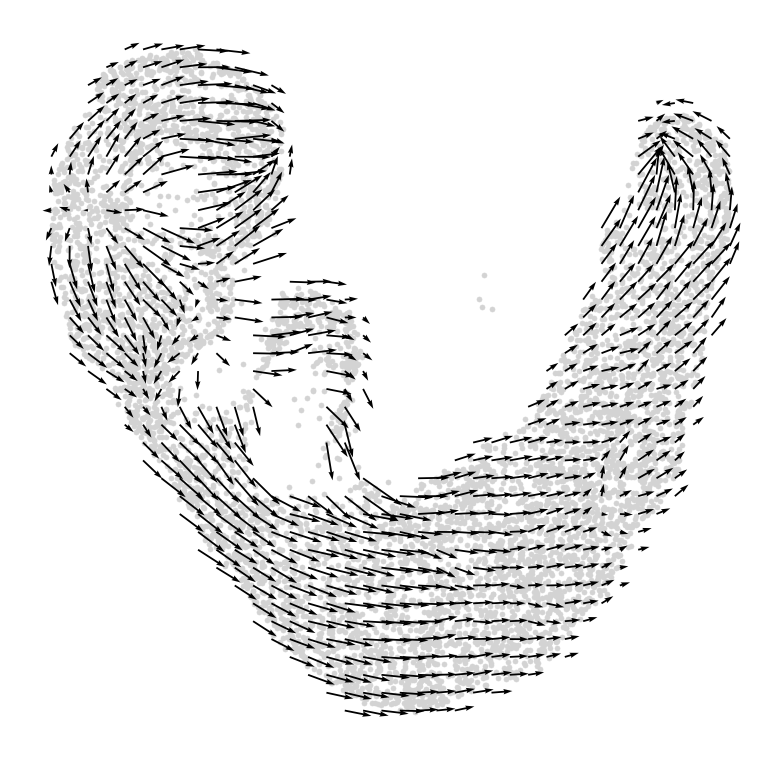

In [16]:
%matplotlib inline

oracle, links, gradient = perturbations.prepare_data(
    oracle_fname='./Oracle.celloracle.oracle', 
    links_fname='./Links.celloracle.links',
    
    palette = None,
    group_by = 'annotation',
    
    grn_fit_ridge_alpha = 10,
    
    p_mass_smooth = 0.8,
    p_mass_n_grid = 40,
    p_mass_n_neighbors = knn,
    p_mass_filter_min = 11,   

    method='knn',
    n_knn=knn,
    n_poly=3,
    scale_dev = 30,
    s=5,
    
    save_dir=None,
    # save_dir='./',
    prefix=None,
    verbose=True)

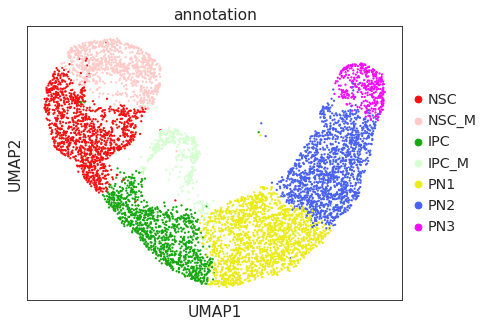

In [23]:
perturbations.sc.pl.umap(oracle.adata, color='annotation')

### KO simulation

In [42]:
all_groups = oracle.adata.obs.annotation.cat.categories.tolist()
groups = {}
groups.update({k: [k] for k in all_groups})
groups.update({'NSCs': [k for k in all_groups if k.startswith('NSC')]})
groups.update({'IPCs': [k for k in all_groups if k.startswith('IPC')]})
groups.update({'PNs': [k for k in all_groups if k.startswith('PN')]})
groups.update({'IPC_PNs': [k for k in all_groups if k.startswith('IPC') or k.startswith('PN')]})
groups

{'NSC': ['NSC'],
 'NSC_M': ['NSC_M'],
 'IPC': ['IPC'],
 'IPC_M': ['IPC_M'],
 'PN1': ['PN1'],
 'PN2': ['PN2'],
 'PN3': ['PN3'],
 'NSCs': ['NSC', 'NSC_M'],
 'IPCs': ['IPC', 'IPC_M'],
 'PNs': ['PN1', 'PN2', 'PN3'],
 'IPC_PNs': ['IPC', 'IPC_M', 'PN1', 'PN2', 'PN3']}

In [43]:
%matplotlib Agg
# %matplotlib inline

In [55]:
oracle.adata.X = oracle.adata.X.toarray()

In [57]:
ps_neurod2 = perturbations.run_systemic_simulation_async(oracle, gradient, 
                                                      
                                                      groups=groups, group_by='annotation',
                                                      
                                                      genes=['Neurod2'],

                                                      p_mass_smooth=0.8,
                                                      p_mass_n_grid=40,
                                                      p_mass_n_neighbors=knn,
                                                      p_mass_filter_min=11,

                                                                  
                                                      n_cores=n_cores, n_parallel_genes=1, overwrite=True)

Excluding: []
Selected number of neighbors: 200


  0%|          | 0/1 [00:00<?, ?it/s]

perturbation_hdf5/KO.Neurod2.celloracle.hdf5


  0%|          | 0/5 [00:00<?, ?it/s]

Calculating expression shift
Estimating transition probabilities
Calculating embedding shift
Calculating p_mass
Running Markov chain simulation
File path: ./perturbations/perturbation_hdf5/KO.Neurod2.celloracle.hdf5
No hdf file found in the path. New hdf5 file was created.
Dumping to ./perturbations/perturbation_hdf5/KO.Neurod2.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Neurod2.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Neurod2.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Neurod2.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Neurod2.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Neurod2.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Neurod2.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Neurod2.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Neurod2.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Neurod2.celloracle.hdf5
Dumpin

  0%|          | 0/5 [00:00<?, ?it/s]

Getting PS for all groups


In [58]:
ps_sums = perturbations.run_systemic_simulation_async(oracle, gradient, 
                                                      
                                                      groups=groups, group_by='annotation',
                                                      
                                                      # genes=['EOMES'],

                                                      p_mass_smooth=0.8,
                                                      p_mass_n_grid=40,
                                                      p_mass_n_neighbors=knn,
                                                      p_mass_filter_min=11,

                                                                  
                                                      n_cores=n_cores, n_parallel_genes=1, overwrite=True)

Excluding: []
Selected number of neighbors: 200


  0%|          | 0/160 [00:00<?, ?it/s]

perturbation_hdf5/KO.Arid5b.celloracle.hdf5


  0%|          | 0/5 [00:00<?, ?it/s]

Calculating expression shift
Estimating transition probabilities
Calculating embedding shift
Calculating p_mass
Running Markov chain simulation
File path: ./perturbations/perturbation_hdf5/KO.Arid5b.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Arid5b.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Arid5b.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Arid5b.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Arid5b.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Arid5b.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Arid5b.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Arid5b.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Arid5b.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Arid5b.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Arid5b.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Arid5b.celloracle.hdf5
Dump

  0%|          | 0/5 [00:00<?, ?it/s]

perturbation_hdf5/KO.Arx.celloracle.hdf5


  0%|          | 0/5 [00:00<?, ?it/s]

Calculating expression shift
Estimating transition probabilities
Calculating embedding shift
Calculating p_mass
Running Markov chain simulation
File path: ./perturbations/perturbation_hdf5/KO.Arx.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Arx.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Arx.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Arx.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Arx.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Arx.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Arx.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Arx.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Arx.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Arx.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Arx.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Arx.celloracle.hdf5
Dumping to ./perturbations/perturbation_

  0%|          | 0/5 [00:00<?, ?it/s]

perturbation_hdf5/KO.Ascl1.celloracle.hdf5


  0%|          | 0/5 [00:00<?, ?it/s]

Calculating expression shift
Estimating transition probabilities
Calculating embedding shift
Calculating p_mass
Running Markov chain simulation
File path: ./perturbations/perturbation_hdf5/KO.Ascl1.celloracle.hdf5
No hdf file found in the path. New hdf5 file was created.
Dumping to ./perturbations/perturbation_hdf5/KO.Ascl1.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Ascl1.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Ascl1.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Ascl1.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Ascl1.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Ascl1.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Ascl1.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Ascl1.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Ascl1.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Ascl1.celloracle.hdf5
Dumping to ./perturbations/p

  0%|          | 0/5 [00:00<?, ?it/s]

perturbation_hdf5/KO.Atf3.celloracle.hdf5


  0%|          | 0/5 [00:00<?, ?it/s]

Calculating expression shift
Estimating transition probabilities
Calculating embedding shift
Calculating p_mass
Running Markov chain simulation
File path: ./perturbations/perturbation_hdf5/KO.Atf3.celloracle.hdf5
No hdf file found in the path. New hdf5 file was created.
Dumping to ./perturbations/perturbation_hdf5/KO.Atf3.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Atf3.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Atf3.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Atf3.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Atf3.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Atf3.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Atf3.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Atf3.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Atf3.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Atf3.celloracle.hdf5
Dumping to ./perturbations/perturbation

  0%|          | 0/5 [00:00<?, ?it/s]

perturbation_hdf5/KO.Bach2.celloracle.hdf5


  0%|          | 0/5 [00:00<?, ?it/s]

Calculating expression shift
Estimating transition probabilities
Calculating embedding shift
Calculating p_mass
Running Markov chain simulation
File path: ./perturbations/perturbation_hdf5/KO.Bach2.celloracle.hdf5
No hdf file found in the path. New hdf5 file was created.
Dumping to ./perturbations/perturbation_hdf5/KO.Bach2.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Bach2.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Bach2.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Bach2.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Bach2.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Bach2.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Bach2.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Bach2.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Bach2.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Bach2.celloracle.hdf5
Dumping to ./perturbations/p

  0%|          | 0/5 [00:00<?, ?it/s]

perturbation_hdf5/KO.Batf3.celloracle.hdf5


  0%|          | 0/5 [00:00<?, ?it/s]

Calculating expression shift
Estimating transition probabilities
Calculating embedding shift
Calculating p_mass
Running Markov chain simulation
File path: ./perturbations/perturbation_hdf5/KO.Batf3.celloracle.hdf5
No hdf file found in the path. New hdf5 file was created.
Dumping to ./perturbations/perturbation_hdf5/KO.Batf3.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Batf3.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Batf3.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Batf3.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Batf3.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Batf3.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Batf3.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Batf3.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Batf3.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Batf3.celloracle.hdf5
Dumping to ./perturbations/p

  0%|          | 0/5 [00:00<?, ?it/s]

perturbation_hdf5/KO.Bcl11a.celloracle.hdf5


  0%|          | 0/5 [00:00<?, ?it/s]

Calculating expression shift
Estimating transition probabilities
Calculating embedding shift
Calculating p_mass
Running Markov chain simulation
File path: ./perturbations/perturbation_hdf5/KO.Bcl11a.celloracle.hdf5
No hdf file found in the path. New hdf5 file was created.
Dumping to ./perturbations/perturbation_hdf5/KO.Bcl11a.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Bcl11a.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Bcl11a.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Bcl11a.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Bcl11a.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Bcl11a.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Bcl11a.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Bcl11a.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Bcl11a.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Bcl11a.celloracle.hdf5
Dumping to ./pert

  0%|          | 0/5 [00:00<?, ?it/s]

perturbation_hdf5/KO.Bcl11b.celloracle.hdf5


  0%|          | 0/5 [00:00<?, ?it/s]

Calculating expression shift
Estimating transition probabilities
Calculating embedding shift
Calculating p_mass
Running Markov chain simulation
File path: ./perturbations/perturbation_hdf5/KO.Bcl11b.celloracle.hdf5
No hdf file found in the path. New hdf5 file was created.
Dumping to ./perturbations/perturbation_hdf5/KO.Bcl11b.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Bcl11b.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Bcl11b.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Bcl11b.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Bcl11b.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Bcl11b.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Bcl11b.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Bcl11b.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Bcl11b.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Bcl11b.celloracle.hdf5
Dumping to ./pert

  0%|          | 0/5 [00:00<?, ?it/s]

perturbation_hdf5/KO.Bhlhe22.celloracle.hdf5


  0%|          | 0/5 [00:00<?, ?it/s]

Calculating expression shift
Estimating transition probabilities
Calculating embedding shift
Calculating p_mass
Running Markov chain simulation
File path: ./perturbations/perturbation_hdf5/KO.Bhlhe22.celloracle.hdf5
No hdf file found in the path. New hdf5 file was created.
Dumping to ./perturbations/perturbation_hdf5/KO.Bhlhe22.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Bhlhe22.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Bhlhe22.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Bhlhe22.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Bhlhe22.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Bhlhe22.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Bhlhe22.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Bhlhe22.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Bhlhe22.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Bhlhe22.celloracle.hdf5
Dumpin

  0%|          | 0/5 [00:00<?, ?it/s]

perturbation_hdf5/KO.Creb5.celloracle.hdf5


  0%|          | 0/5 [00:00<?, ?it/s]

Calculating expression shift
Estimating transition probabilities
Calculating embedding shift
Calculating p_mass
Running Markov chain simulation
File path: ./perturbations/perturbation_hdf5/KO.Creb5.celloracle.hdf5
No hdf file found in the path. New hdf5 file was created.
Dumping to ./perturbations/perturbation_hdf5/KO.Creb5.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Creb5.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Creb5.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Creb5.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Creb5.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Creb5.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Creb5.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Creb5.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Creb5.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Creb5.celloracle.hdf5
Dumping to ./perturbations/p

  0%|          | 0/5 [00:00<?, ?it/s]

perturbation_hdf5/KO.Cux1.celloracle.hdf5


  0%|          | 0/5 [00:00<?, ?it/s]

Calculating expression shift
Estimating transition probabilities
Calculating embedding shift
Calculating p_mass
Running Markov chain simulation
File path: ./perturbations/perturbation_hdf5/KO.Cux1.celloracle.hdf5
No hdf file found in the path. New hdf5 file was created.
Dumping to ./perturbations/perturbation_hdf5/KO.Cux1.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Cux1.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Cux1.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Cux1.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Cux1.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Cux1.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Cux1.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Cux1.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Cux1.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Cux1.celloracle.hdf5
Dumping to ./perturbations/perturbation

  0%|          | 0/5 [00:00<?, ?it/s]

perturbation_hdf5/KO.Cux2.celloracle.hdf5


  0%|          | 0/5 [00:00<?, ?it/s]

Calculating expression shift
Estimating transition probabilities
Calculating embedding shift
Calculating p_mass
Running Markov chain simulation
File path: ./perturbations/perturbation_hdf5/KO.Cux2.celloracle.hdf5
No hdf file found in the path. New hdf5 file was created.
Dumping to ./perturbations/perturbation_hdf5/KO.Cux2.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Cux2.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Cux2.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Cux2.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Cux2.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Cux2.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Cux2.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Cux2.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Cux2.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Cux2.celloracle.hdf5
Dumping to ./perturbations/perturbation

  0%|          | 0/5 [00:00<?, ?it/s]

perturbation_hdf5/KO.Dbx1.celloracle.hdf5


  0%|          | 0/5 [00:00<?, ?it/s]

Calculating expression shift
Estimating transition probabilities
Calculating embedding shift
Calculating p_mass
Running Markov chain simulation
File path: ./perturbations/perturbation_hdf5/KO.Dbx1.celloracle.hdf5
No hdf file found in the path. New hdf5 file was created.
Dumping to ./perturbations/perturbation_hdf5/KO.Dbx1.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Dbx1.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Dbx1.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Dbx1.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Dbx1.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Dbx1.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Dbx1.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Dbx1.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Dbx1.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Dbx1.celloracle.hdf5
Dumping to ./perturbations/perturbation

  0%|          | 0/5 [00:00<?, ?it/s]

perturbation_hdf5/KO.Dlx1.celloracle.hdf5


  0%|          | 0/5 [00:00<?, ?it/s]

Calculating expression shift
Estimating transition probabilities
Calculating embedding shift
Calculating p_mass
Running Markov chain simulation
File path: ./perturbations/perturbation_hdf5/KO.Dlx1.celloracle.hdf5
No hdf file found in the path. New hdf5 file was created.
Dumping to ./perturbations/perturbation_hdf5/KO.Dlx1.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Dlx1.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Dlx1.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Dlx1.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Dlx1.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Dlx1.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Dlx1.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Dlx1.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Dlx1.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Dlx1.celloracle.hdf5
Dumping to ./perturbations/perturbation

  0%|          | 0/5 [00:00<?, ?it/s]

perturbation_hdf5/KO.Dlx2.celloracle.hdf5


  0%|          | 0/5 [00:00<?, ?it/s]

Calculating expression shift
Estimating transition probabilities
Calculating embedding shift
Calculating p_mass
Running Markov chain simulation
File path: ./perturbations/perturbation_hdf5/KO.Dlx2.celloracle.hdf5
No hdf file found in the path. New hdf5 file was created.
Dumping to ./perturbations/perturbation_hdf5/KO.Dlx2.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Dlx2.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Dlx2.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Dlx2.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Dlx2.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Dlx2.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Dlx2.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Dlx2.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Dlx2.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Dlx2.celloracle.hdf5
Dumping to ./perturbations/perturbation

  0%|          | 0/5 [00:00<?, ?it/s]

perturbation_hdf5/KO.Dlx5.celloracle.hdf5


  0%|          | 0/5 [00:00<?, ?it/s]

Calculating expression shift
Estimating transition probabilities
Calculating embedding shift
Calculating p_mass
Running Markov chain simulation
File path: ./perturbations/perturbation_hdf5/KO.Dlx5.celloracle.hdf5
No hdf file found in the path. New hdf5 file was created.
Dumping to ./perturbations/perturbation_hdf5/KO.Dlx5.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Dlx5.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Dlx5.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Dlx5.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Dlx5.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Dlx5.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Dlx5.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Dlx5.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Dlx5.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Dlx5.celloracle.hdf5
Dumping to ./perturbations/perturbation

  0%|          | 0/5 [00:00<?, ?it/s]

perturbation_hdf5/KO.Dmrt2.celloracle.hdf5


  0%|          | 0/5 [00:00<?, ?it/s]

Calculating expression shift
Estimating transition probabilities
Calculating embedding shift
Calculating p_mass
Running Markov chain simulation
File path: ./perturbations/perturbation_hdf5/KO.Dmrt2.celloracle.hdf5
No hdf file found in the path. New hdf5 file was created.
Dumping to ./perturbations/perturbation_hdf5/KO.Dmrt2.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Dmrt2.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Dmrt2.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Dmrt2.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Dmrt2.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Dmrt2.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Dmrt2.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Dmrt2.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Dmrt2.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Dmrt2.celloracle.hdf5
Dumping to ./perturbations/p

  0%|          | 0/5 [00:00<?, ?it/s]

perturbation_hdf5/KO.Dmrta1.celloracle.hdf5


  0%|          | 0/5 [00:00<?, ?it/s]

Calculating expression shift
Estimating transition probabilities
Calculating embedding shift
Calculating p_mass
Running Markov chain simulation
File path: ./perturbations/perturbation_hdf5/KO.Dmrta1.celloracle.hdf5
No hdf file found in the path. New hdf5 file was created.
Dumping to ./perturbations/perturbation_hdf5/KO.Dmrta1.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Dmrta1.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Dmrta1.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Dmrta1.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Dmrta1.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Dmrta1.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Dmrta1.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Dmrta1.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Dmrta1.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Dmrta1.celloracle.hdf5
Dumping to ./pert

  0%|          | 0/5 [00:00<?, ?it/s]

perturbation_hdf5/KO.E2f1.celloracle.hdf5


  0%|          | 0/5 [00:00<?, ?it/s]

Calculating expression shift
Estimating transition probabilities
Calculating embedding shift
Calculating p_mass
Running Markov chain simulation
File path: ./perturbations/perturbation_hdf5/KO.E2f1.celloracle.hdf5
No hdf file found in the path. New hdf5 file was created.
Dumping to ./perturbations/perturbation_hdf5/KO.E2f1.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.E2f1.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.E2f1.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.E2f1.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.E2f1.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.E2f1.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.E2f1.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.E2f1.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.E2f1.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.E2f1.celloracle.hdf5
Dumping to ./perturbations/perturbation

  0%|          | 0/5 [00:00<?, ?it/s]

perturbation_hdf5/KO.E2f2.celloracle.hdf5


  0%|          | 0/5 [00:00<?, ?it/s]

Calculating expression shift
Estimating transition probabilities
Calculating embedding shift
Calculating p_mass
Running Markov chain simulation
File path: ./perturbations/perturbation_hdf5/KO.E2f2.celloracle.hdf5
No hdf file found in the path. New hdf5 file was created.
Dumping to ./perturbations/perturbation_hdf5/KO.E2f2.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.E2f2.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.E2f2.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.E2f2.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.E2f2.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.E2f2.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.E2f2.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.E2f2.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.E2f2.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.E2f2.celloracle.hdf5
Dumping to ./perturbations/perturbation

  0%|          | 0/5 [00:00<?, ?it/s]

perturbation_hdf5/KO.E2f3.celloracle.hdf5


  0%|          | 0/5 [00:00<?, ?it/s]

Calculating expression shift
Estimating transition probabilities
Calculating embedding shift
Calculating p_mass
Running Markov chain simulation
File path: ./perturbations/perturbation_hdf5/KO.E2f3.celloracle.hdf5
No hdf file found in the path. New hdf5 file was created.
Dumping to ./perturbations/perturbation_hdf5/KO.E2f3.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.E2f3.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.E2f3.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.E2f3.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.E2f3.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.E2f3.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.E2f3.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.E2f3.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.E2f3.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.E2f3.celloracle.hdf5
Dumping to ./perturbations/perturbation

  0%|          | 0/5 [00:00<?, ?it/s]

perturbation_hdf5/KO.E2f7.celloracle.hdf5


  0%|          | 0/5 [00:00<?, ?it/s]

Calculating expression shift
Estimating transition probabilities
Calculating embedding shift
Calculating p_mass
Running Markov chain simulation
File path: ./perturbations/perturbation_hdf5/KO.E2f7.celloracle.hdf5
No hdf file found in the path. New hdf5 file was created.
Dumping to ./perturbations/perturbation_hdf5/KO.E2f7.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.E2f7.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.E2f7.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.E2f7.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.E2f7.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.E2f7.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.E2f7.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.E2f7.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.E2f7.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.E2f7.celloracle.hdf5
Dumping to ./perturbations/perturbation

  0%|          | 0/5 [00:00<?, ?it/s]

perturbation_hdf5/KO.E2f8.celloracle.hdf5


  0%|          | 0/5 [00:00<?, ?it/s]

Calculating expression shift
Estimating transition probabilities
Calculating embedding shift
Calculating p_mass
Running Markov chain simulation
File path: ./perturbations/perturbation_hdf5/KO.E2f8.celloracle.hdf5
No hdf file found in the path. New hdf5 file was created.
Dumping to ./perturbations/perturbation_hdf5/KO.E2f8.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.E2f8.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.E2f8.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.E2f8.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.E2f8.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.E2f8.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.E2f8.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.E2f8.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.E2f8.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.E2f8.celloracle.hdf5
Dumping to ./perturbations/perturbation

  0%|          | 0/5 [00:00<?, ?it/s]

perturbation_hdf5/KO.Ebf1.celloracle.hdf5


  0%|          | 0/5 [00:00<?, ?it/s]

Calculating expression shift
Estimating transition probabilities
Calculating embedding shift
Calculating p_mass
Running Markov chain simulation
File path: ./perturbations/perturbation_hdf5/KO.Ebf1.celloracle.hdf5
No hdf file found in the path. New hdf5 file was created.
Dumping to ./perturbations/perturbation_hdf5/KO.Ebf1.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Ebf1.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Ebf1.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Ebf1.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Ebf1.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Ebf1.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Ebf1.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Ebf1.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Ebf1.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Ebf1.celloracle.hdf5
Dumping to ./perturbations/perturbation

  0%|          | 0/5 [00:00<?, ?it/s]

perturbation_hdf5/KO.Egr1.celloracle.hdf5


  0%|          | 0/5 [00:00<?, ?it/s]

Calculating expression shift
Estimating transition probabilities
Calculating embedding shift
Calculating p_mass
Running Markov chain simulation
File path: ./perturbations/perturbation_hdf5/KO.Egr1.celloracle.hdf5
No hdf file found in the path. New hdf5 file was created.
Dumping to ./perturbations/perturbation_hdf5/KO.Egr1.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Egr1.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Egr1.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Egr1.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Egr1.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Egr1.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Egr1.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Egr1.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Egr1.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Egr1.celloracle.hdf5
Dumping to ./perturbations/perturbation

  0%|          | 0/5 [00:00<?, ?it/s]

perturbation_hdf5/KO.Egr2.celloracle.hdf5


  0%|          | 0/5 [00:00<?, ?it/s]

Calculating expression shift
Estimating transition probabilities
Calculating embedding shift
Calculating p_mass
Running Markov chain simulation
File path: ./perturbations/perturbation_hdf5/KO.Egr2.celloracle.hdf5
No hdf file found in the path. New hdf5 file was created.
Dumping to ./perturbations/perturbation_hdf5/KO.Egr2.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Egr2.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Egr2.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Egr2.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Egr2.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Egr2.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Egr2.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Egr2.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Egr2.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Egr2.celloracle.hdf5
Dumping to ./perturbations/perturbation

  0%|          | 0/5 [00:00<?, ?it/s]

perturbation_hdf5/KO.Egr3.celloracle.hdf5


  0%|          | 0/5 [00:00<?, ?it/s]

Calculating expression shift
Estimating transition probabilities
Calculating embedding shift
Calculating p_mass
Running Markov chain simulation
File path: ./perturbations/perturbation_hdf5/KO.Egr3.celloracle.hdf5
No hdf file found in the path. New hdf5 file was created.
Dumping to ./perturbations/perturbation_hdf5/KO.Egr3.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Egr3.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Egr3.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Egr3.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Egr3.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Egr3.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Egr3.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Egr3.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Egr3.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Egr3.celloracle.hdf5
Dumping to ./perturbations/perturbation

  0%|          | 0/5 [00:00<?, ?it/s]

perturbation_hdf5/KO.Emx1.celloracle.hdf5


  0%|          | 0/5 [00:00<?, ?it/s]

Calculating expression shift
Estimating transition probabilities
Calculating embedding shift
Calculating p_mass
Running Markov chain simulation
File path: ./perturbations/perturbation_hdf5/KO.Emx1.celloracle.hdf5
No hdf file found in the path. New hdf5 file was created.
Dumping to ./perturbations/perturbation_hdf5/KO.Emx1.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Emx1.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Emx1.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Emx1.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Emx1.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Emx1.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Emx1.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Emx1.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Emx1.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Emx1.celloracle.hdf5
Dumping to ./perturbations/perturbation

  0%|          | 0/5 [00:00<?, ?it/s]

perturbation_hdf5/KO.Eomes.celloracle.hdf5


  0%|          | 0/5 [00:00<?, ?it/s]

Calculating expression shift
Estimating transition probabilities
Calculating embedding shift
Calculating p_mass
Running Markov chain simulation
File path: ./perturbations/perturbation_hdf5/KO.Eomes.celloracle.hdf5
No hdf file found in the path. New hdf5 file was created.
Dumping to ./perturbations/perturbation_hdf5/KO.Eomes.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Eomes.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Eomes.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Eomes.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Eomes.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Eomes.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Eomes.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Eomes.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Eomes.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Eomes.celloracle.hdf5
Dumping to ./perturbations/p

  0%|          | 0/5 [00:00<?, ?it/s]

perturbation_hdf5/KO.Erf.celloracle.hdf5


  0%|          | 0/5 [00:00<?, ?it/s]

Calculating expression shift
Estimating transition probabilities
Calculating embedding shift
Calculating p_mass
Running Markov chain simulation
File path: ./perturbations/perturbation_hdf5/KO.Erf.celloracle.hdf5
No hdf file found in the path. New hdf5 file was created.
Dumping to ./perturbations/perturbation_hdf5/KO.Erf.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Erf.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Erf.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Erf.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Erf.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Erf.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Erf.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Erf.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Erf.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Erf.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Er

  0%|          | 0/5 [00:00<?, ?it/s]

perturbation_hdf5/KO.Etv1.celloracle.hdf5


  0%|          | 0/5 [00:00<?, ?it/s]

Calculating expression shift
Estimating transition probabilities
Calculating embedding shift
Calculating p_mass
Running Markov chain simulation
File path: ./perturbations/perturbation_hdf5/KO.Etv1.celloracle.hdf5
No hdf file found in the path. New hdf5 file was created.
Dumping to ./perturbations/perturbation_hdf5/KO.Etv1.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Etv1.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Etv1.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Etv1.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Etv1.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Etv1.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Etv1.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Etv1.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Etv1.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Etv1.celloracle.hdf5
Dumping to ./perturbations/perturbation

  0%|          | 0/5 [00:00<?, ?it/s]

perturbation_hdf5/KO.Etv4.celloracle.hdf5


  0%|          | 0/5 [00:00<?, ?it/s]

Calculating expression shift
Estimating transition probabilities
Calculating embedding shift
Calculating p_mass
Running Markov chain simulation
File path: ./perturbations/perturbation_hdf5/KO.Etv4.celloracle.hdf5
No hdf file found in the path. New hdf5 file was created.
Dumping to ./perturbations/perturbation_hdf5/KO.Etv4.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Etv4.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Etv4.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Etv4.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Etv4.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Etv4.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Etv4.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Etv4.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Etv4.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Etv4.celloracle.hdf5
Dumping to ./perturbations/perturbation

  0%|          | 0/5 [00:00<?, ?it/s]

perturbation_hdf5/KO.Etv5.celloracle.hdf5


  0%|          | 0/5 [00:00<?, ?it/s]

Calculating expression shift
Estimating transition probabilities
Calculating embedding shift
Calculating p_mass
Running Markov chain simulation
File path: ./perturbations/perturbation_hdf5/KO.Etv5.celloracle.hdf5
No hdf file found in the path. New hdf5 file was created.
Dumping to ./perturbations/perturbation_hdf5/KO.Etv5.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Etv5.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Etv5.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Etv5.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Etv5.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Etv5.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Etv5.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Etv5.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Etv5.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Etv5.celloracle.hdf5
Dumping to ./perturbations/perturbation

  0%|          | 0/5 [00:00<?, ?it/s]

perturbation_hdf5/KO.Fos.celloracle.hdf5


  0%|          | 0/5 [00:00<?, ?it/s]

Calculating expression shift
Estimating transition probabilities
Calculating embedding shift
Calculating p_mass
Running Markov chain simulation
File path: ./perturbations/perturbation_hdf5/KO.Fos.celloracle.hdf5
No hdf file found in the path. New hdf5 file was created.
Dumping to ./perturbations/perturbation_hdf5/KO.Fos.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Fos.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Fos.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Fos.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Fos.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Fos.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Fos.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Fos.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Fos.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Fos.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Fo

  0%|          | 0/5 [00:00<?, ?it/s]

perturbation_hdf5/KO.Fosb.celloracle.hdf5


  0%|          | 0/5 [00:00<?, ?it/s]

Calculating expression shift
Estimating transition probabilities
Calculating embedding shift
Calculating p_mass
Running Markov chain simulation
File path: ./perturbations/perturbation_hdf5/KO.Fosb.celloracle.hdf5
No hdf file found in the path. New hdf5 file was created.
Dumping to ./perturbations/perturbation_hdf5/KO.Fosb.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Fosb.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Fosb.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Fosb.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Fosb.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Fosb.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Fosb.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Fosb.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Fosb.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Fosb.celloracle.hdf5
Dumping to ./perturbations/perturbation

  0%|          | 0/5 [00:00<?, ?it/s]

perturbation_hdf5/KO.Foxm1.celloracle.hdf5


  0%|          | 0/5 [00:00<?, ?it/s]

Calculating expression shift
Estimating transition probabilities
Calculating embedding shift
Calculating p_mass
Running Markov chain simulation
File path: ./perturbations/perturbation_hdf5/KO.Foxm1.celloracle.hdf5
No hdf file found in the path. New hdf5 file was created.
Dumping to ./perturbations/perturbation_hdf5/KO.Foxm1.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Foxm1.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Foxm1.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Foxm1.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Foxm1.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Foxm1.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Foxm1.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Foxm1.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Foxm1.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Foxm1.celloracle.hdf5
Dumping to ./perturbations/p

  0%|          | 0/5 [00:00<?, ?it/s]

perturbation_hdf5/KO.Foxp2.celloracle.hdf5


  0%|          | 0/5 [00:00<?, ?it/s]

Calculating expression shift
Estimating transition probabilities
Calculating embedding shift
Calculating p_mass
Running Markov chain simulation
File path: ./perturbations/perturbation_hdf5/KO.Foxp2.celloracle.hdf5
No hdf file found in the path. New hdf5 file was created.
Dumping to ./perturbations/perturbation_hdf5/KO.Foxp2.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Foxp2.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Foxp2.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Foxp2.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Foxp2.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Foxp2.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Foxp2.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Foxp2.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Foxp2.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Foxp2.celloracle.hdf5
Dumping to ./perturbations/p

  0%|          | 0/5 [00:00<?, ?it/s]

perturbation_hdf5/KO.Foxp4.celloracle.hdf5


  0%|          | 0/5 [00:00<?, ?it/s]

Calculating expression shift
Estimating transition probabilities
Calculating embedding shift
Calculating p_mass
Running Markov chain simulation
File path: ./perturbations/perturbation_hdf5/KO.Foxp4.celloracle.hdf5
No hdf file found in the path. New hdf5 file was created.
Dumping to ./perturbations/perturbation_hdf5/KO.Foxp4.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Foxp4.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Foxp4.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Foxp4.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Foxp4.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Foxp4.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Foxp4.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Foxp4.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Foxp4.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Foxp4.celloracle.hdf5
Dumping to ./perturbations/p

  0%|          | 0/5 [00:00<?, ?it/s]

perturbation_hdf5/KO.Gli3.celloracle.hdf5


  0%|          | 0/5 [00:00<?, ?it/s]

Calculating expression shift
Estimating transition probabilities
Calculating embedding shift
Calculating p_mass
Running Markov chain simulation
File path: ./perturbations/perturbation_hdf5/KO.Gli3.celloracle.hdf5
No hdf file found in the path. New hdf5 file was created.
Dumping to ./perturbations/perturbation_hdf5/KO.Gli3.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Gli3.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Gli3.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Gli3.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Gli3.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Gli3.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Gli3.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Gli3.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Gli3.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Gli3.celloracle.hdf5
Dumping to ./perturbations/perturbation

  0%|          | 0/5 [00:00<?, ?it/s]

perturbation_hdf5/KO.Hivep2.celloracle.hdf5


  0%|          | 0/5 [00:00<?, ?it/s]

Calculating expression shift
Estimating transition probabilities
Calculating embedding shift
Calculating p_mass
Running Markov chain simulation
File path: ./perturbations/perturbation_hdf5/KO.Hivep2.celloracle.hdf5
No hdf file found in the path. New hdf5 file was created.
Dumping to ./perturbations/perturbation_hdf5/KO.Hivep2.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Hivep2.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Hivep2.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Hivep2.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Hivep2.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Hivep2.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Hivep2.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Hivep2.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Hivep2.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Hivep2.celloracle.hdf5
Dumping to ./pert

  0%|          | 0/5 [00:00<?, ?it/s]

perturbation_hdf5/KO.Hivep3.celloracle.hdf5


  0%|          | 0/5 [00:00<?, ?it/s]

Calculating expression shift
Estimating transition probabilities
Calculating embedding shift
Calculating p_mass
Running Markov chain simulation
File path: ./perturbations/perturbation_hdf5/KO.Hivep3.celloracle.hdf5
No hdf file found in the path. New hdf5 file was created.
Dumping to ./perturbations/perturbation_hdf5/KO.Hivep3.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Hivep3.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Hivep3.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Hivep3.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Hivep3.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Hivep3.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Hivep3.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Hivep3.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Hivep3.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Hivep3.celloracle.hdf5
Dumping to ./pert

  0%|          | 0/5 [00:00<?, ?it/s]

perturbation_hdf5/KO.Hlf.celloracle.hdf5


  0%|          | 0/5 [00:00<?, ?it/s]

Calculating expression shift
Estimating transition probabilities
Calculating embedding shift
Calculating p_mass
Running Markov chain simulation
File path: ./perturbations/perturbation_hdf5/KO.Hlf.celloracle.hdf5
No hdf file found in the path. New hdf5 file was created.
Dumping to ./perturbations/perturbation_hdf5/KO.Hlf.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Hlf.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Hlf.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Hlf.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Hlf.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Hlf.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Hlf.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Hlf.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Hlf.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Hlf.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Hl

  0%|          | 0/5 [00:00<?, ?it/s]

perturbation_hdf5/KO.Hmx1.celloracle.hdf5


  0%|          | 0/5 [00:00<?, ?it/s]

Calculating expression shift
Estimating transition probabilities
Calculating embedding shift
Calculating p_mass
Running Markov chain simulation
File path: ./perturbations/perturbation_hdf5/KO.Hmx1.celloracle.hdf5
No hdf file found in the path. New hdf5 file was created.
Dumping to ./perturbations/perturbation_hdf5/KO.Hmx1.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Hmx1.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Hmx1.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Hmx1.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Hmx1.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Hmx1.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Hmx1.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Hmx1.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Hmx1.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Hmx1.celloracle.hdf5
Dumping to ./perturbations/perturbation

  0%|          | 0/5 [00:00<?, ?it/s]

perturbation_hdf5/KO.Id1.celloracle.hdf5


  0%|          | 0/5 [00:00<?, ?it/s]

Calculating expression shift
Estimating transition probabilities
Calculating embedding shift
Calculating p_mass
Running Markov chain simulation
File path: ./perturbations/perturbation_hdf5/KO.Id1.celloracle.hdf5
No hdf file found in the path. New hdf5 file was created.
Dumping to ./perturbations/perturbation_hdf5/KO.Id1.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Id1.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Id1.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Id1.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Id1.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Id1.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Id1.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Id1.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Id1.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Id1.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Id

  0%|          | 0/5 [00:00<?, ?it/s]

perturbation_hdf5/KO.Id2.celloracle.hdf5


  0%|          | 0/5 [00:00<?, ?it/s]

Calculating expression shift
Estimating transition probabilities
Calculating embedding shift
Calculating p_mass
Running Markov chain simulation
File path: ./perturbations/perturbation_hdf5/KO.Id2.celloracle.hdf5
No hdf file found in the path. New hdf5 file was created.
Dumping to ./perturbations/perturbation_hdf5/KO.Id2.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Id2.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Id2.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Id2.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Id2.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Id2.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Id2.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Id2.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Id2.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Id2.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Id

  0%|          | 0/5 [00:00<?, ?it/s]

perturbation_hdf5/KO.Id3.celloracle.hdf5


  0%|          | 0/5 [00:00<?, ?it/s]

Calculating expression shift
Estimating transition probabilities
Calculating embedding shift
Calculating p_mass
Running Markov chain simulation
File path: ./perturbations/perturbation_hdf5/KO.Id3.celloracle.hdf5
No hdf file found in the path. New hdf5 file was created.
Dumping to ./perturbations/perturbation_hdf5/KO.Id3.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Id3.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Id3.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Id3.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Id3.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Id3.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Id3.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Id3.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Id3.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Id3.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Id

  0%|          | 0/5 [00:00<?, ?it/s]

perturbation_hdf5/KO.Id4.celloracle.hdf5


  0%|          | 0/5 [00:00<?, ?it/s]

Calculating expression shift
Estimating transition probabilities
Calculating embedding shift
Calculating p_mass
Running Markov chain simulation
File path: ./perturbations/perturbation_hdf5/KO.Id4.celloracle.hdf5
No hdf file found in the path. New hdf5 file was created.
Dumping to ./perturbations/perturbation_hdf5/KO.Id4.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Id4.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Id4.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Id4.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Id4.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Id4.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Id4.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Id4.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Id4.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Id4.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Id

  0%|          | 0/5 [00:00<?, ?it/s]

perturbation_hdf5/KO.Ikzf1.celloracle.hdf5


  0%|          | 0/5 [00:00<?, ?it/s]

Calculating expression shift
Estimating transition probabilities
Calculating embedding shift
Calculating p_mass
Running Markov chain simulation
File path: ./perturbations/perturbation_hdf5/KO.Ikzf1.celloracle.hdf5
No hdf file found in the path. New hdf5 file was created.
Dumping to ./perturbations/perturbation_hdf5/KO.Ikzf1.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Ikzf1.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Ikzf1.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Ikzf1.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Ikzf1.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Ikzf1.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Ikzf1.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Ikzf1.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Ikzf1.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Ikzf1.celloracle.hdf5
Dumping to ./perturbations/p

  0%|          | 0/5 [00:00<?, ?it/s]

perturbation_hdf5/KO.Insm1.celloracle.hdf5


  0%|          | 0/5 [00:00<?, ?it/s]

Calculating expression shift
Estimating transition probabilities
Calculating embedding shift
Calculating p_mass
Running Markov chain simulation
File path: ./perturbations/perturbation_hdf5/KO.Insm1.celloracle.hdf5
No hdf file found in the path. New hdf5 file was created.
Dumping to ./perturbations/perturbation_hdf5/KO.Insm1.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Insm1.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Insm1.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Insm1.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Insm1.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Insm1.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Insm1.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Insm1.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Insm1.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Insm1.celloracle.hdf5
Dumping to ./perturbations/p

  0%|          | 0/5 [00:00<?, ?it/s]

perturbation_hdf5/KO.Irx2.celloracle.hdf5


  0%|          | 0/5 [00:00<?, ?it/s]

Calculating expression shift
Estimating transition probabilities
Calculating embedding shift
Calculating p_mass
Running Markov chain simulation
File path: ./perturbations/perturbation_hdf5/KO.Irx2.celloracle.hdf5
No hdf file found in the path. New hdf5 file was created.
Dumping to ./perturbations/perturbation_hdf5/KO.Irx2.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Irx2.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Irx2.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Irx2.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Irx2.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Irx2.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Irx2.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Irx2.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Irx2.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Irx2.celloracle.hdf5
Dumping to ./perturbations/perturbation

  0%|          | 0/5 [00:00<?, ?it/s]

perturbation_hdf5/KO.Jun.celloracle.hdf5


  0%|          | 0/5 [00:00<?, ?it/s]

Calculating expression shift
Estimating transition probabilities
Calculating embedding shift
Calculating p_mass
Running Markov chain simulation
File path: ./perturbations/perturbation_hdf5/KO.Jun.celloracle.hdf5
No hdf file found in the path. New hdf5 file was created.
Dumping to ./perturbations/perturbation_hdf5/KO.Jun.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Jun.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Jun.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Jun.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Jun.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Jun.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Jun.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Jun.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Jun.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Jun.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Ju

  0%|          | 0/5 [00:00<?, ?it/s]

perturbation_hdf5/KO.Junb.celloracle.hdf5


  0%|          | 0/5 [00:00<?, ?it/s]

Calculating expression shift
Estimating transition probabilities
Calculating embedding shift
Calculating p_mass
Running Markov chain simulation
File path: ./perturbations/perturbation_hdf5/KO.Junb.celloracle.hdf5
No hdf file found in the path. New hdf5 file was created.
Dumping to ./perturbations/perturbation_hdf5/KO.Junb.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Junb.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Junb.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Junb.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Junb.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Junb.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Junb.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Junb.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Junb.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Junb.celloracle.hdf5
Dumping to ./perturbations/perturbation

  0%|          | 0/5 [00:00<?, ?it/s]

perturbation_hdf5/KO.Jund.celloracle.hdf5


  0%|          | 0/5 [00:00<?, ?it/s]

Calculating expression shift
Estimating transition probabilities
Calculating embedding shift
Calculating p_mass
Running Markov chain simulation
File path: ./perturbations/perturbation_hdf5/KO.Jund.celloracle.hdf5
No hdf file found in the path. New hdf5 file was created.
Dumping to ./perturbations/perturbation_hdf5/KO.Jund.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Jund.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Jund.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Jund.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Jund.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Jund.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Jund.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Jund.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Jund.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Jund.celloracle.hdf5
Dumping to ./perturbations/perturbation

  0%|          | 0/5 [00:00<?, ?it/s]

perturbation_hdf5/KO.Klf10.celloracle.hdf5


  0%|          | 0/5 [00:00<?, ?it/s]

Calculating expression shift
Estimating transition probabilities
Calculating embedding shift
Calculating p_mass
Running Markov chain simulation
File path: ./perturbations/perturbation_hdf5/KO.Klf10.celloracle.hdf5
No hdf file found in the path. New hdf5 file was created.
Dumping to ./perturbations/perturbation_hdf5/KO.Klf10.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Klf10.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Klf10.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Klf10.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Klf10.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Klf10.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Klf10.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Klf10.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Klf10.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Klf10.celloracle.hdf5
Dumping to ./perturbations/p

  0%|          | 0/5 [00:00<?, ?it/s]

perturbation_hdf5/KO.Klf3.celloracle.hdf5


  0%|          | 0/5 [00:00<?, ?it/s]

Calculating expression shift
Estimating transition probabilities
Calculating embedding shift
Calculating p_mass
Running Markov chain simulation
File path: ./perturbations/perturbation_hdf5/KO.Klf3.celloracle.hdf5
No hdf file found in the path. New hdf5 file was created.
Dumping to ./perturbations/perturbation_hdf5/KO.Klf3.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Klf3.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Klf3.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Klf3.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Klf3.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Klf3.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Klf3.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Klf3.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Klf3.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Klf3.celloracle.hdf5
Dumping to ./perturbations/perturbation

  0%|          | 0/5 [00:00<?, ?it/s]

perturbation_hdf5/KO.Klf4.celloracle.hdf5


  0%|          | 0/5 [00:00<?, ?it/s]

Calculating expression shift
Estimating transition probabilities
Calculating embedding shift
Calculating p_mass
Running Markov chain simulation
File path: ./perturbations/perturbation_hdf5/KO.Klf4.celloracle.hdf5
No hdf file found in the path. New hdf5 file was created.
Dumping to ./perturbations/perturbation_hdf5/KO.Klf4.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Klf4.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Klf4.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Klf4.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Klf4.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Klf4.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Klf4.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Klf4.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Klf4.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Klf4.celloracle.hdf5
Dumping to ./perturbations/perturbation

  0%|          | 0/5 [00:00<?, ?it/s]

perturbation_hdf5/KO.Klf5.celloracle.hdf5


  0%|          | 0/5 [00:00<?, ?it/s]

Calculating expression shift
Estimating transition probabilities
Calculating embedding shift
Calculating p_mass
Running Markov chain simulation
File path: ./perturbations/perturbation_hdf5/KO.Klf5.celloracle.hdf5
No hdf file found in the path. New hdf5 file was created.
Dumping to ./perturbations/perturbation_hdf5/KO.Klf5.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Klf5.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Klf5.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Klf5.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Klf5.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Klf5.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Klf5.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Klf5.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Klf5.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Klf5.celloracle.hdf5
Dumping to ./perturbations/perturbation

  0%|          | 0/5 [00:00<?, ?it/s]

perturbation_hdf5/KO.Klf6.celloracle.hdf5


  0%|          | 0/5 [00:00<?, ?it/s]

Calculating expression shift
Estimating transition probabilities
Calculating embedding shift
Calculating p_mass
Running Markov chain simulation
File path: ./perturbations/perturbation_hdf5/KO.Klf6.celloracle.hdf5
No hdf file found in the path. New hdf5 file was created.
Dumping to ./perturbations/perturbation_hdf5/KO.Klf6.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Klf6.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Klf6.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Klf6.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Klf6.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Klf6.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Klf6.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Klf6.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Klf6.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Klf6.celloracle.hdf5
Dumping to ./perturbations/perturbation

  0%|          | 0/5 [00:00<?, ?it/s]

perturbation_hdf5/KO.Klf7.celloracle.hdf5


  0%|          | 0/5 [00:00<?, ?it/s]

Calculating expression shift
Estimating transition probabilities
Calculating embedding shift
Calculating p_mass
Running Markov chain simulation
File path: ./perturbations/perturbation_hdf5/KO.Klf7.celloracle.hdf5
No hdf file found in the path. New hdf5 file was created.
Dumping to ./perturbations/perturbation_hdf5/KO.Klf7.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Klf7.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Klf7.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Klf7.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Klf7.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Klf7.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Klf7.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Klf7.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Klf7.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Klf7.celloracle.hdf5
Dumping to ./perturbations/perturbation

  0%|          | 0/5 [00:00<?, ?it/s]

perturbation_hdf5/KO.Klf9.celloracle.hdf5


  0%|          | 0/5 [00:00<?, ?it/s]

Calculating expression shift
Estimating transition probabilities
Calculating embedding shift
Calculating p_mass
Running Markov chain simulation
File path: ./perturbations/perturbation_hdf5/KO.Klf9.celloracle.hdf5
No hdf file found in the path. New hdf5 file was created.
Dumping to ./perturbations/perturbation_hdf5/KO.Klf9.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Klf9.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Klf9.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Klf9.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Klf9.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Klf9.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Klf9.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Klf9.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Klf9.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Klf9.celloracle.hdf5
Dumping to ./perturbations/perturbation

  0%|          | 0/5 [00:00<?, ?it/s]

perturbation_hdf5/KO.Lhx1.celloracle.hdf5


  0%|          | 0/5 [00:00<?, ?it/s]

Calculating expression shift
Estimating transition probabilities
Calculating embedding shift
Calculating p_mass
Running Markov chain simulation
File path: ./perturbations/perturbation_hdf5/KO.Lhx1.celloracle.hdf5
No hdf file found in the path. New hdf5 file was created.
Dumping to ./perturbations/perturbation_hdf5/KO.Lhx1.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Lhx1.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Lhx1.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Lhx1.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Lhx1.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Lhx1.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Lhx1.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Lhx1.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Lhx1.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Lhx1.celloracle.hdf5
Dumping to ./perturbations/perturbation

  0%|          | 0/5 [00:00<?, ?it/s]

perturbation_hdf5/KO.Lhx2.celloracle.hdf5


  0%|          | 0/5 [00:00<?, ?it/s]

Calculating expression shift
Estimating transition probabilities
Calculating embedding shift
Calculating p_mass
Running Markov chain simulation
File path: ./perturbations/perturbation_hdf5/KO.Lhx2.celloracle.hdf5
No hdf file found in the path. New hdf5 file was created.
Dumping to ./perturbations/perturbation_hdf5/KO.Lhx2.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Lhx2.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Lhx2.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Lhx2.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Lhx2.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Lhx2.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Lhx2.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Lhx2.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Lhx2.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Lhx2.celloracle.hdf5
Dumping to ./perturbations/perturbation

  0%|          | 0/5 [00:00<?, ?it/s]

perturbation_hdf5/KO.Lhx6.celloracle.hdf5


  0%|          | 0/5 [00:00<?, ?it/s]

Calculating expression shift
Estimating transition probabilities
Calculating embedding shift
Calculating p_mass
Running Markov chain simulation
File path: ./perturbations/perturbation_hdf5/KO.Lhx6.celloracle.hdf5
No hdf file found in the path. New hdf5 file was created.
Dumping to ./perturbations/perturbation_hdf5/KO.Lhx6.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Lhx6.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Lhx6.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Lhx6.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Lhx6.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Lhx6.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Lhx6.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Lhx6.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Lhx6.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Lhx6.celloracle.hdf5
Dumping to ./perturbations/perturbation

  0%|          | 0/5 [00:00<?, ?it/s]

perturbation_hdf5/KO.Lhx9.celloracle.hdf5


  0%|          | 0/5 [00:00<?, ?it/s]

Calculating expression shift
Estimating transition probabilities
Calculating embedding shift
Calculating p_mass
Running Markov chain simulation
File path: ./perturbations/perturbation_hdf5/KO.Lhx9.celloracle.hdf5
No hdf file found in the path. New hdf5 file was created.
Dumping to ./perturbations/perturbation_hdf5/KO.Lhx9.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Lhx9.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Lhx9.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Lhx9.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Lhx9.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Lhx9.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Lhx9.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Lhx9.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Lhx9.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Lhx9.celloracle.hdf5
Dumping to ./perturbations/perturbation

  0%|          | 0/5 [00:00<?, ?it/s]

perturbation_hdf5/KO.Lmx1a.celloracle.hdf5


  0%|          | 0/5 [00:00<?, ?it/s]

Calculating expression shift
Estimating transition probabilities
Calculating embedding shift
Calculating p_mass
Running Markov chain simulation
File path: ./perturbations/perturbation_hdf5/KO.Lmx1a.celloracle.hdf5
No hdf file found in the path. New hdf5 file was created.
Dumping to ./perturbations/perturbation_hdf5/KO.Lmx1a.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Lmx1a.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Lmx1a.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Lmx1a.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Lmx1a.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Lmx1a.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Lmx1a.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Lmx1a.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Lmx1a.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Lmx1a.celloracle.hdf5
Dumping to ./perturbations/p

  0%|          | 0/5 [00:00<?, ?it/s]

perturbation_hdf5/KO.Maf.celloracle.hdf5


  0%|          | 0/5 [00:00<?, ?it/s]

Calculating expression shift
Estimating transition probabilities
Calculating embedding shift
Calculating p_mass
Running Markov chain simulation
File path: ./perturbations/perturbation_hdf5/KO.Maf.celloracle.hdf5
No hdf file found in the path. New hdf5 file was created.
Dumping to ./perturbations/perturbation_hdf5/KO.Maf.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Maf.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Maf.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Maf.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Maf.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Maf.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Maf.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Maf.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Maf.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Maf.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Ma

  0%|          | 0/5 [00:00<?, ?it/s]

perturbation_hdf5/KO.Mafa.celloracle.hdf5


  0%|          | 0/5 [00:00<?, ?it/s]

Calculating expression shift
Estimating transition probabilities
Calculating embedding shift
Calculating p_mass
Running Markov chain simulation
File path: ./perturbations/perturbation_hdf5/KO.Mafa.celloracle.hdf5
No hdf file found in the path. New hdf5 file was created.
Dumping to ./perturbations/perturbation_hdf5/KO.Mafa.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Mafa.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Mafa.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Mafa.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Mafa.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Mafa.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Mafa.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Mafa.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Mafa.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Mafa.celloracle.hdf5
Dumping to ./perturbations/perturbation

  0%|          | 0/5 [00:00<?, ?it/s]

perturbation_hdf5/KO.Mafb.celloracle.hdf5


  0%|          | 0/5 [00:00<?, ?it/s]

Calculating expression shift
Estimating transition probabilities
Calculating embedding shift
Calculating p_mass
Running Markov chain simulation
File path: ./perturbations/perturbation_hdf5/KO.Mafb.celloracle.hdf5
No hdf file found in the path. New hdf5 file was created.
Dumping to ./perturbations/perturbation_hdf5/KO.Mafb.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Mafb.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Mafb.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Mafb.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Mafb.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Mafb.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Mafb.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Mafb.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Mafb.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Mafb.celloracle.hdf5
Dumping to ./perturbations/perturbation

  0%|          | 0/5 [00:00<?, ?it/s]

perturbation_hdf5/KO.Mef2c.celloracle.hdf5


  0%|          | 0/5 [00:00<?, ?it/s]

Calculating expression shift
Estimating transition probabilities
Calculating embedding shift
Calculating p_mass
Running Markov chain simulation
File path: ./perturbations/perturbation_hdf5/KO.Mef2c.celloracle.hdf5
No hdf file found in the path. New hdf5 file was created.
Dumping to ./perturbations/perturbation_hdf5/KO.Mef2c.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Mef2c.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Mef2c.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Mef2c.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Mef2c.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Mef2c.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Mef2c.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Mef2c.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Mef2c.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Mef2c.celloracle.hdf5
Dumping to ./perturbations/p

  0%|          | 0/5 [00:00<?, ?it/s]

perturbation_hdf5/KO.Meis2.celloracle.hdf5


  0%|          | 0/5 [00:00<?, ?it/s]

Calculating expression shift
Estimating transition probabilities
Calculating embedding shift
Calculating p_mass
Running Markov chain simulation
File path: ./perturbations/perturbation_hdf5/KO.Meis2.celloracle.hdf5
No hdf file found in the path. New hdf5 file was created.
Dumping to ./perturbations/perturbation_hdf5/KO.Meis2.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Meis2.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Meis2.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Meis2.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Meis2.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Meis2.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Meis2.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Meis2.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Meis2.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Meis2.celloracle.hdf5
Dumping to ./perturbations/p

  0%|          | 0/5 [00:00<?, ?it/s]

perturbation_hdf5/KO.Mitf.celloracle.hdf5


  0%|          | 0/5 [00:00<?, ?it/s]

Calculating expression shift
Estimating transition probabilities
Calculating embedding shift
Calculating p_mass
Running Markov chain simulation
File path: ./perturbations/perturbation_hdf5/KO.Mitf.celloracle.hdf5
No hdf file found in the path. New hdf5 file was created.
Dumping to ./perturbations/perturbation_hdf5/KO.Mitf.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Mitf.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Mitf.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Mitf.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Mitf.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Mitf.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Mitf.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Mitf.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Mitf.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Mitf.celloracle.hdf5
Dumping to ./perturbations/perturbation

  0%|          | 0/5 [00:00<?, ?it/s]

perturbation_hdf5/KO.Msx2.celloracle.hdf5


  0%|          | 0/5 [00:00<?, ?it/s]

Calculating expression shift
Estimating transition probabilities
Calculating embedding shift
Calculating p_mass
Running Markov chain simulation
File path: ./perturbations/perturbation_hdf5/KO.Msx2.celloracle.hdf5
No hdf file found in the path. New hdf5 file was created.
Dumping to ./perturbations/perturbation_hdf5/KO.Msx2.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Msx2.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Msx2.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Msx2.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Msx2.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Msx2.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Msx2.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Msx2.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Msx2.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Msx2.celloracle.hdf5
Dumping to ./perturbations/perturbation

  0%|          | 0/5 [00:00<?, ?it/s]

perturbation_hdf5/KO.Mxi1.celloracle.hdf5


  0%|          | 0/5 [00:00<?, ?it/s]

Calculating expression shift
Estimating transition probabilities
Calculating embedding shift
Calculating p_mass
Running Markov chain simulation
File path: ./perturbations/perturbation_hdf5/KO.Mxi1.celloracle.hdf5
No hdf file found in the path. New hdf5 file was created.
Dumping to ./perturbations/perturbation_hdf5/KO.Mxi1.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Mxi1.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Mxi1.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Mxi1.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Mxi1.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Mxi1.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Mxi1.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Mxi1.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Mxi1.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Mxi1.celloracle.hdf5
Dumping to ./perturbations/perturbation

  0%|          | 0/5 [00:00<?, ?it/s]

perturbation_hdf5/KO.Mybl1.celloracle.hdf5


  0%|          | 0/5 [00:00<?, ?it/s]

Calculating expression shift
Estimating transition probabilities
Calculating embedding shift
Calculating p_mass
Running Markov chain simulation
File path: ./perturbations/perturbation_hdf5/KO.Mybl1.celloracle.hdf5
No hdf file found in the path. New hdf5 file was created.
Dumping to ./perturbations/perturbation_hdf5/KO.Mybl1.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Mybl1.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Mybl1.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Mybl1.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Mybl1.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Mybl1.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Mybl1.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Mybl1.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Mybl1.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Mybl1.celloracle.hdf5
Dumping to ./perturbations/p

  0%|          | 0/5 [00:00<?, ?it/s]

perturbation_hdf5/KO.Mybl2.celloracle.hdf5


  0%|          | 0/5 [00:00<?, ?it/s]

Calculating expression shift
Estimating transition probabilities
Calculating embedding shift
Calculating p_mass
Running Markov chain simulation
File path: ./perturbations/perturbation_hdf5/KO.Mybl2.celloracle.hdf5
No hdf file found in the path. New hdf5 file was created.
Dumping to ./perturbations/perturbation_hdf5/KO.Mybl2.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Mybl2.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Mybl2.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Mybl2.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Mybl2.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Mybl2.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Mybl2.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Mybl2.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Mybl2.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Mybl2.celloracle.hdf5
Dumping to ./perturbations/p

  0%|          | 0/5 [00:00<?, ?it/s]

perturbation_hdf5/KO.Myc.celloracle.hdf5


  0%|          | 0/5 [00:00<?, ?it/s]

Calculating expression shift
Estimating transition probabilities
Calculating embedding shift
Calculating p_mass
Running Markov chain simulation
File path: ./perturbations/perturbation_hdf5/KO.Myc.celloracle.hdf5
No hdf file found in the path. New hdf5 file was created.
Dumping to ./perturbations/perturbation_hdf5/KO.Myc.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Myc.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Myc.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Myc.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Myc.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Myc.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Myc.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Myc.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Myc.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Myc.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.My

  0%|          | 0/5 [00:00<?, ?it/s]

perturbation_hdf5/KO.Neurod1.celloracle.hdf5


  0%|          | 0/5 [00:00<?, ?it/s]

Calculating expression shift
Estimating transition probabilities
Calculating embedding shift
Calculating p_mass
Running Markov chain simulation
File path: ./perturbations/perturbation_hdf5/KO.Neurod1.celloracle.hdf5
No hdf file found in the path. New hdf5 file was created.
Dumping to ./perturbations/perturbation_hdf5/KO.Neurod1.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Neurod1.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Neurod1.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Neurod1.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Neurod1.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Neurod1.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Neurod1.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Neurod1.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Neurod1.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Neurod1.celloracle.hdf5
Dumpin

  0%|          | 0/5 [00:00<?, ?it/s]

perturbation_hdf5/KO.Neurod2.celloracle.hdf5


  0%|          | 0/5 [00:00<?, ?it/s]

Calculating expression shift
Estimating transition probabilities
Calculating embedding shift
Calculating p_mass
Running Markov chain simulation
File path: ./perturbations/perturbation_hdf5/KO.Neurod2.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Neurod2.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Neurod2.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Neurod2.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Neurod2.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Neurod2.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Neurod2.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Neurod2.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Neurod2.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Neurod2.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Neurod2.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Neurod2.cellorac

  0%|          | 0/5 [00:00<?, ?it/s]

perturbation_hdf5/KO.Neurod4.celloracle.hdf5


  0%|          | 0/5 [00:00<?, ?it/s]

Calculating expression shift
Estimating transition probabilities
Calculating embedding shift
Calculating p_mass
Running Markov chain simulation
File path: ./perturbations/perturbation_hdf5/KO.Neurod4.celloracle.hdf5
No hdf file found in the path. New hdf5 file was created.
Dumping to ./perturbations/perturbation_hdf5/KO.Neurod4.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Neurod4.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Neurod4.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Neurod4.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Neurod4.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Neurod4.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Neurod4.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Neurod4.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Neurod4.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Neurod4.celloracle.hdf5
Dumpin

  0%|          | 0/5 [00:00<?, ?it/s]

perturbation_hdf5/KO.Neurod6.celloracle.hdf5


  0%|          | 0/5 [00:00<?, ?it/s]

Calculating expression shift
Estimating transition probabilities
Calculating embedding shift
Calculating p_mass
Running Markov chain simulation
File path: ./perturbations/perturbation_hdf5/KO.Neurod6.celloracle.hdf5
No hdf file found in the path. New hdf5 file was created.
Dumping to ./perturbations/perturbation_hdf5/KO.Neurod6.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Neurod6.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Neurod6.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Neurod6.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Neurod6.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Neurod6.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Neurod6.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Neurod6.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Neurod6.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Neurod6.celloracle.hdf5
Dumpin

  0%|          | 0/5 [00:00<?, ?it/s]

perturbation_hdf5/KO.Neurog1.celloracle.hdf5


  0%|          | 0/5 [00:00<?, ?it/s]

Calculating expression shift
Estimating transition probabilities
Calculating embedding shift
Calculating p_mass
Running Markov chain simulation
File path: ./perturbations/perturbation_hdf5/KO.Neurog1.celloracle.hdf5
No hdf file found in the path. New hdf5 file was created.
Dumping to ./perturbations/perturbation_hdf5/KO.Neurog1.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Neurog1.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Neurog1.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Neurog1.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Neurog1.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Neurog1.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Neurog1.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Neurog1.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Neurog1.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Neurog1.celloracle.hdf5
Dumpin

  0%|          | 0/5 [00:00<?, ?it/s]

perturbation_hdf5/KO.Neurog2.celloracle.hdf5


  0%|          | 0/5 [00:00<?, ?it/s]

Calculating expression shift
Estimating transition probabilities
Calculating embedding shift
Calculating p_mass
Running Markov chain simulation
File path: ./perturbations/perturbation_hdf5/KO.Neurog2.celloracle.hdf5
No hdf file found in the path. New hdf5 file was created.
Dumping to ./perturbations/perturbation_hdf5/KO.Neurog2.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Neurog2.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Neurog2.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Neurog2.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Neurog2.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Neurog2.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Neurog2.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Neurog2.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Neurog2.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Neurog2.celloracle.hdf5
Dumpin

  0%|          | 0/5 [00:00<?, ?it/s]

perturbation_hdf5/KO.Nfat5.celloracle.hdf5


  0%|          | 0/5 [00:00<?, ?it/s]

Calculating expression shift
Estimating transition probabilities
Calculating embedding shift
Calculating p_mass
Running Markov chain simulation
File path: ./perturbations/perturbation_hdf5/KO.Nfat5.celloracle.hdf5
No hdf file found in the path. New hdf5 file was created.
Dumping to ./perturbations/perturbation_hdf5/KO.Nfat5.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Nfat5.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Nfat5.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Nfat5.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Nfat5.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Nfat5.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Nfat5.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Nfat5.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Nfat5.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Nfat5.celloracle.hdf5
Dumping to ./perturbations/p

  0%|          | 0/5 [00:00<?, ?it/s]

perturbation_hdf5/KO.Nfatc1.celloracle.hdf5


  0%|          | 0/5 [00:00<?, ?it/s]

Calculating expression shift
Estimating transition probabilities
Calculating embedding shift
Calculating p_mass
Running Markov chain simulation
File path: ./perturbations/perturbation_hdf5/KO.Nfatc1.celloracle.hdf5
No hdf file found in the path. New hdf5 file was created.
Dumping to ./perturbations/perturbation_hdf5/KO.Nfatc1.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Nfatc1.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Nfatc1.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Nfatc1.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Nfatc1.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Nfatc1.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Nfatc1.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Nfatc1.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Nfatc1.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Nfatc1.celloracle.hdf5
Dumping to ./pert

  0%|          | 0/5 [00:00<?, ?it/s]

perturbation_hdf5/KO.Nfatc2.celloracle.hdf5


  0%|          | 0/5 [00:00<?, ?it/s]

Calculating expression shift
Estimating transition probabilities
Calculating embedding shift
Calculating p_mass
Running Markov chain simulation
File path: ./perturbations/perturbation_hdf5/KO.Nfatc2.celloracle.hdf5
No hdf file found in the path. New hdf5 file was created.
Dumping to ./perturbations/perturbation_hdf5/KO.Nfatc2.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Nfatc2.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Nfatc2.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Nfatc2.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Nfatc2.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Nfatc2.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Nfatc2.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Nfatc2.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Nfatc2.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Nfatc2.celloracle.hdf5
Dumping to ./pert

  0%|          | 0/5 [00:00<?, ?it/s]

perturbation_hdf5/KO.Nfatc4.celloracle.hdf5


  0%|          | 0/5 [00:00<?, ?it/s]

Calculating expression shift
Estimating transition probabilities
Calculating embedding shift
Calculating p_mass
Running Markov chain simulation
File path: ./perturbations/perturbation_hdf5/KO.Nfatc4.celloracle.hdf5
No hdf file found in the path. New hdf5 file was created.
Dumping to ./perturbations/perturbation_hdf5/KO.Nfatc4.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Nfatc4.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Nfatc4.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Nfatc4.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Nfatc4.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Nfatc4.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Nfatc4.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Nfatc4.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Nfatc4.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Nfatc4.celloracle.hdf5
Dumping to ./pert

  0%|          | 0/5 [00:00<?, ?it/s]

perturbation_hdf5/KO.Nfe2l2.celloracle.hdf5


  0%|          | 0/5 [00:00<?, ?it/s]

Calculating expression shift
Estimating transition probabilities
Calculating embedding shift
Calculating p_mass
Running Markov chain simulation
File path: ./perturbations/perturbation_hdf5/KO.Nfe2l2.celloracle.hdf5
No hdf file found in the path. New hdf5 file was created.
Dumping to ./perturbations/perturbation_hdf5/KO.Nfe2l2.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Nfe2l2.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Nfe2l2.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Nfe2l2.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Nfe2l2.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Nfe2l2.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Nfe2l2.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Nfe2l2.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Nfe2l2.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Nfe2l2.celloracle.hdf5
Dumping to ./pert

  0%|          | 0/5 [00:00<?, ?it/s]

perturbation_hdf5/KO.Nfia.celloracle.hdf5


  0%|          | 0/5 [00:00<?, ?it/s]

Calculating expression shift
Estimating transition probabilities
Calculating embedding shift
Calculating p_mass
Running Markov chain simulation
File path: ./perturbations/perturbation_hdf5/KO.Nfia.celloracle.hdf5
No hdf file found in the path. New hdf5 file was created.
Dumping to ./perturbations/perturbation_hdf5/KO.Nfia.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Nfia.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Nfia.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Nfia.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Nfia.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Nfia.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Nfia.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Nfia.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Nfia.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Nfia.celloracle.hdf5
Dumping to ./perturbations/perturbation

  0%|          | 0/5 [00:00<?, ?it/s]

perturbation_hdf5/KO.Nfib.celloracle.hdf5


  0%|          | 0/5 [00:00<?, ?it/s]

Calculating expression shift
Estimating transition probabilities
Calculating embedding shift
Calculating p_mass
Running Markov chain simulation
File path: ./perturbations/perturbation_hdf5/KO.Nfib.celloracle.hdf5
No hdf file found in the path. New hdf5 file was created.
Dumping to ./perturbations/perturbation_hdf5/KO.Nfib.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Nfib.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Nfib.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Nfib.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Nfib.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Nfib.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Nfib.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Nfib.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Nfib.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Nfib.celloracle.hdf5
Dumping to ./perturbations/perturbation

  0%|          | 0/5 [00:00<?, ?it/s]

perturbation_hdf5/KO.Nfic.celloracle.hdf5


  0%|          | 0/5 [00:00<?, ?it/s]

Calculating expression shift
Estimating transition probabilities
Calculating embedding shift
Calculating p_mass
Running Markov chain simulation
File path: ./perturbations/perturbation_hdf5/KO.Nfic.celloracle.hdf5
No hdf file found in the path. New hdf5 file was created.
Dumping to ./perturbations/perturbation_hdf5/KO.Nfic.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Nfic.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Nfic.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Nfic.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Nfic.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Nfic.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Nfic.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Nfic.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Nfic.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Nfic.celloracle.hdf5
Dumping to ./perturbations/perturbation

  0%|          | 0/5 [00:00<?, ?it/s]

perturbation_hdf5/KO.Nfil3.celloracle.hdf5


  0%|          | 0/5 [00:00<?, ?it/s]

Calculating expression shift
Estimating transition probabilities
Calculating embedding shift
Calculating p_mass
Running Markov chain simulation
File path: ./perturbations/perturbation_hdf5/KO.Nfil3.celloracle.hdf5
No hdf file found in the path. New hdf5 file was created.
Dumping to ./perturbations/perturbation_hdf5/KO.Nfil3.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Nfil3.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Nfil3.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Nfil3.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Nfil3.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Nfil3.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Nfil3.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Nfil3.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Nfil3.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Nfil3.celloracle.hdf5
Dumping to ./perturbations/p

  0%|          | 0/5 [00:00<?, ?it/s]

perturbation_hdf5/KO.Nfix.celloracle.hdf5


  0%|          | 0/5 [00:00<?, ?it/s]

Calculating expression shift
Estimating transition probabilities
Calculating embedding shift
Calculating p_mass
Running Markov chain simulation
File path: ./perturbations/perturbation_hdf5/KO.Nfix.celloracle.hdf5
No hdf file found in the path. New hdf5 file was created.
Dumping to ./perturbations/perturbation_hdf5/KO.Nfix.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Nfix.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Nfix.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Nfix.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Nfix.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Nfix.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Nfix.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Nfix.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Nfix.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Nfix.celloracle.hdf5
Dumping to ./perturbations/perturbation

  0%|          | 0/5 [00:00<?, ?it/s]

perturbation_hdf5/KO.Nfya.celloracle.hdf5


  0%|          | 0/5 [00:00<?, ?it/s]

Calculating expression shift
Estimating transition probabilities
Calculating embedding shift
Calculating p_mass
Running Markov chain simulation
File path: ./perturbations/perturbation_hdf5/KO.Nfya.celloracle.hdf5
No hdf file found in the path. New hdf5 file was created.
Dumping to ./perturbations/perturbation_hdf5/KO.Nfya.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Nfya.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Nfya.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Nfya.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Nfya.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Nfya.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Nfya.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Nfya.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Nfya.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Nfya.celloracle.hdf5
Dumping to ./perturbations/perturbation

  0%|          | 0/5 [00:00<?, ?it/s]

perturbation_hdf5/KO.Nhlh1.celloracle.hdf5


  0%|          | 0/5 [00:00<?, ?it/s]

Calculating expression shift
Estimating transition probabilities
Calculating embedding shift
Calculating p_mass
Running Markov chain simulation
File path: ./perturbations/perturbation_hdf5/KO.Nhlh1.celloracle.hdf5
No hdf file found in the path. New hdf5 file was created.
Dumping to ./perturbations/perturbation_hdf5/KO.Nhlh1.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Nhlh1.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Nhlh1.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Nhlh1.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Nhlh1.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Nhlh1.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Nhlh1.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Nhlh1.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Nhlh1.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Nhlh1.celloracle.hdf5
Dumping to ./perturbations/p

  0%|          | 0/5 [00:00<?, ?it/s]

perturbation_hdf5/KO.Nkx3-1.celloracle.hdf5


  0%|          | 0/5 [00:00<?, ?it/s]

Calculating expression shift
Estimating transition probabilities
Calculating embedding shift
Calculating p_mass
Running Markov chain simulation
File path: ./perturbations/perturbation_hdf5/KO.Nkx3-1.celloracle.hdf5
No hdf file found in the path. New hdf5 file was created.
Dumping to ./perturbations/perturbation_hdf5/KO.Nkx3-1.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Nkx3-1.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Nkx3-1.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Nkx3-1.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Nkx3-1.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Nkx3-1.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Nkx3-1.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Nkx3-1.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Nkx3-1.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Nkx3-1.celloracle.hdf5
Dumping to ./pert

  0%|          | 0/5 [00:00<?, ?it/s]

perturbation_hdf5/KO.Npas3.celloracle.hdf5


  0%|          | 0/5 [00:00<?, ?it/s]

Calculating expression shift
Estimating transition probabilities
Calculating embedding shift
Calculating p_mass
Running Markov chain simulation
File path: ./perturbations/perturbation_hdf5/KO.Npas3.celloracle.hdf5
No hdf file found in the path. New hdf5 file was created.
Dumping to ./perturbations/perturbation_hdf5/KO.Npas3.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Npas3.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Npas3.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Npas3.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Npas3.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Npas3.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Npas3.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Npas3.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Npas3.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Npas3.celloracle.hdf5
Dumping to ./perturbations/p

  0%|          | 0/5 [00:00<?, ?it/s]

perturbation_hdf5/KO.Nr2e1.celloracle.hdf5


  0%|          | 0/5 [00:00<?, ?it/s]

Calculating expression shift
Estimating transition probabilities
Calculating embedding shift
Calculating p_mass
Running Markov chain simulation
File path: ./perturbations/perturbation_hdf5/KO.Nr2e1.celloracle.hdf5
No hdf file found in the path. New hdf5 file was created.
Dumping to ./perturbations/perturbation_hdf5/KO.Nr2e1.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Nr2e1.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Nr2e1.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Nr2e1.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Nr2e1.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Nr2e1.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Nr2e1.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Nr2e1.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Nr2e1.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Nr2e1.celloracle.hdf5
Dumping to ./perturbations/p

  0%|          | 0/5 [00:00<?, ?it/s]

perturbation_hdf5/KO.Nr2f1.celloracle.hdf5


  0%|          | 0/5 [00:00<?, ?it/s]

Calculating expression shift
Estimating transition probabilities
Calculating embedding shift
Calculating p_mass
Running Markov chain simulation
File path: ./perturbations/perturbation_hdf5/KO.Nr2f1.celloracle.hdf5
No hdf file found in the path. New hdf5 file was created.
Dumping to ./perturbations/perturbation_hdf5/KO.Nr2f1.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Nr2f1.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Nr2f1.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Nr2f1.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Nr2f1.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Nr2f1.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Nr2f1.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Nr2f1.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Nr2f1.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Nr2f1.celloracle.hdf5
Dumping to ./perturbations/p

  0%|          | 0/5 [00:00<?, ?it/s]

perturbation_hdf5/KO.Nr2f2.celloracle.hdf5


  0%|          | 0/5 [00:00<?, ?it/s]

Calculating expression shift
Estimating transition probabilities
Calculating embedding shift
Calculating p_mass
Running Markov chain simulation
File path: ./perturbations/perturbation_hdf5/KO.Nr2f2.celloracle.hdf5
No hdf file found in the path. New hdf5 file was created.
Dumping to ./perturbations/perturbation_hdf5/KO.Nr2f2.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Nr2f2.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Nr2f2.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Nr2f2.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Nr2f2.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Nr2f2.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Nr2f2.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Nr2f2.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Nr2f2.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Nr2f2.celloracle.hdf5
Dumping to ./perturbations/p

  0%|          | 0/5 [00:00<?, ?it/s]

perturbation_hdf5/KO.Nr3c1.celloracle.hdf5


  0%|          | 0/5 [00:00<?, ?it/s]

Calculating expression shift
Estimating transition probabilities
Calculating embedding shift
Calculating p_mass
Running Markov chain simulation
File path: ./perturbations/perturbation_hdf5/KO.Nr3c1.celloracle.hdf5
No hdf file found in the path. New hdf5 file was created.
Dumping to ./perturbations/perturbation_hdf5/KO.Nr3c1.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Nr3c1.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Nr3c1.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Nr3c1.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Nr3c1.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Nr3c1.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Nr3c1.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Nr3c1.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Nr3c1.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Nr3c1.celloracle.hdf5
Dumping to ./perturbations/p

  0%|          | 0/5 [00:00<?, ?it/s]

perturbation_hdf5/KO.Nr3c2.celloracle.hdf5


  0%|          | 0/5 [00:00<?, ?it/s]

Calculating expression shift
Estimating transition probabilities
Calculating embedding shift
Calculating p_mass
Running Markov chain simulation
File path: ./perturbations/perturbation_hdf5/KO.Nr3c2.celloracle.hdf5
No hdf file found in the path. New hdf5 file was created.
Dumping to ./perturbations/perturbation_hdf5/KO.Nr3c2.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Nr3c2.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Nr3c2.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Nr3c2.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Nr3c2.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Nr3c2.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Nr3c2.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Nr3c2.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Nr3c2.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Nr3c2.celloracle.hdf5
Dumping to ./perturbations/p

  0%|          | 0/5 [00:00<?, ?it/s]

perturbation_hdf5/KO.Nr4a2.celloracle.hdf5


  0%|          | 0/5 [00:00<?, ?it/s]

Calculating expression shift
Estimating transition probabilities
Calculating embedding shift
Calculating p_mass
Running Markov chain simulation
File path: ./perturbations/perturbation_hdf5/KO.Nr4a2.celloracle.hdf5
No hdf file found in the path. New hdf5 file was created.
Dumping to ./perturbations/perturbation_hdf5/KO.Nr4a2.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Nr4a2.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Nr4a2.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Nr4a2.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Nr4a2.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Nr4a2.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Nr4a2.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Nr4a2.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Nr4a2.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Nr4a2.celloracle.hdf5
Dumping to ./perturbations/p

  0%|          | 0/5 [00:00<?, ?it/s]

perturbation_hdf5/KO.Nr4a3.celloracle.hdf5


  0%|          | 0/5 [00:00<?, ?it/s]

Calculating expression shift
Estimating transition probabilities
Calculating embedding shift
Calculating p_mass
Running Markov chain simulation
File path: ./perturbations/perturbation_hdf5/KO.Nr4a3.celloracle.hdf5
No hdf file found in the path. New hdf5 file was created.
Dumping to ./perturbations/perturbation_hdf5/KO.Nr4a3.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Nr4a3.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Nr4a3.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Nr4a3.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Nr4a3.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Nr4a3.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Nr4a3.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Nr4a3.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Nr4a3.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Nr4a3.celloracle.hdf5
Dumping to ./perturbations/p

  0%|          | 0/5 [00:00<?, ?it/s]

perturbation_hdf5/KO.Onecut2.celloracle.hdf5


  0%|          | 0/5 [00:00<?, ?it/s]

Calculating expression shift
Estimating transition probabilities
Calculating embedding shift
Calculating p_mass
Running Markov chain simulation
File path: ./perturbations/perturbation_hdf5/KO.Onecut2.celloracle.hdf5
No hdf file found in the path. New hdf5 file was created.
Dumping to ./perturbations/perturbation_hdf5/KO.Onecut2.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Onecut2.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Onecut2.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Onecut2.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Onecut2.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Onecut2.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Onecut2.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Onecut2.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Onecut2.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Onecut2.celloracle.hdf5
Dumpin

  0%|          | 0/5 [00:00<?, ?it/s]

perturbation_hdf5/KO.Otx1.celloracle.hdf5


  0%|          | 0/5 [00:00<?, ?it/s]

Calculating expression shift
Estimating transition probabilities
Calculating embedding shift
Calculating p_mass
Running Markov chain simulation
File path: ./perturbations/perturbation_hdf5/KO.Otx1.celloracle.hdf5
No hdf file found in the path. New hdf5 file was created.
Dumping to ./perturbations/perturbation_hdf5/KO.Otx1.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Otx1.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Otx1.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Otx1.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Otx1.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Otx1.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Otx1.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Otx1.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Otx1.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Otx1.celloracle.hdf5
Dumping to ./perturbations/perturbation

  0%|          | 0/5 [00:00<?, ?it/s]

perturbation_hdf5/KO.Pax2.celloracle.hdf5


  0%|          | 0/5 [00:00<?, ?it/s]

Calculating expression shift
Estimating transition probabilities
Calculating embedding shift
Calculating p_mass
Running Markov chain simulation
File path: ./perturbations/perturbation_hdf5/KO.Pax2.celloracle.hdf5
No hdf file found in the path. New hdf5 file was created.
Dumping to ./perturbations/perturbation_hdf5/KO.Pax2.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Pax2.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Pax2.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Pax2.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Pax2.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Pax2.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Pax2.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Pax2.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Pax2.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Pax2.celloracle.hdf5
Dumping to ./perturbations/perturbation

  0%|          | 0/5 [00:00<?, ?it/s]

perturbation_hdf5/KO.Pax4.celloracle.hdf5


  0%|          | 0/5 [00:00<?, ?it/s]

Calculating expression shift
Estimating transition probabilities
Calculating embedding shift
Calculating p_mass
Running Markov chain simulation
File path: ./perturbations/perturbation_hdf5/KO.Pax4.celloracle.hdf5
No hdf file found in the path. New hdf5 file was created.
Dumping to ./perturbations/perturbation_hdf5/KO.Pax4.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Pax4.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Pax4.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Pax4.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Pax4.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Pax4.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Pax4.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Pax4.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Pax4.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Pax4.celloracle.hdf5
Dumping to ./perturbations/perturbation

  0%|          | 0/5 [00:00<?, ?it/s]

perturbation_hdf5/KO.Pax6.celloracle.hdf5


  0%|          | 0/5 [00:00<?, ?it/s]

Calculating expression shift
Estimating transition probabilities
Calculating embedding shift
Calculating p_mass
Running Markov chain simulation
File path: ./perturbations/perturbation_hdf5/KO.Pax6.celloracle.hdf5
No hdf file found in the path. New hdf5 file was created.
Dumping to ./perturbations/perturbation_hdf5/KO.Pax6.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Pax6.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Pax6.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Pax6.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Pax6.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Pax6.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Pax6.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Pax6.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Pax6.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Pax6.celloracle.hdf5
Dumping to ./perturbations/perturbation

  0%|          | 0/5 [00:00<?, ?it/s]

perturbation_hdf5/KO.Pbx3.celloracle.hdf5


  0%|          | 0/5 [00:00<?, ?it/s]

Calculating expression shift
Estimating transition probabilities
Calculating embedding shift
Calculating p_mass
Running Markov chain simulation
File path: ./perturbations/perturbation_hdf5/KO.Pbx3.celloracle.hdf5
No hdf file found in the path. New hdf5 file was created.
Dumping to ./perturbations/perturbation_hdf5/KO.Pbx3.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Pbx3.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Pbx3.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Pbx3.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Pbx3.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Pbx3.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Pbx3.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Pbx3.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Pbx3.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Pbx3.celloracle.hdf5
Dumping to ./perturbations/perturbation

  0%|          | 0/5 [00:00<?, ?it/s]

perturbation_hdf5/KO.Plagl1.celloracle.hdf5


  0%|          | 0/5 [00:00<?, ?it/s]

Calculating expression shift
Estimating transition probabilities
Calculating embedding shift
Calculating p_mass
Running Markov chain simulation
File path: ./perturbations/perturbation_hdf5/KO.Plagl1.celloracle.hdf5
No hdf file found in the path. New hdf5 file was created.
Dumping to ./perturbations/perturbation_hdf5/KO.Plagl1.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Plagl1.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Plagl1.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Plagl1.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Plagl1.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Plagl1.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Plagl1.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Plagl1.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Plagl1.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Plagl1.celloracle.hdf5
Dumping to ./pert

  0%|          | 0/5 [00:00<?, ?it/s]

perturbation_hdf5/KO.Pou2f2.celloracle.hdf5


  0%|          | 0/5 [00:00<?, ?it/s]

Calculating expression shift
Estimating transition probabilities
Calculating embedding shift
Calculating p_mass
Running Markov chain simulation
File path: ./perturbations/perturbation_hdf5/KO.Pou2f2.celloracle.hdf5
No hdf file found in the path. New hdf5 file was created.
Dumping to ./perturbations/perturbation_hdf5/KO.Pou2f2.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Pou2f2.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Pou2f2.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Pou2f2.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Pou2f2.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Pou2f2.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Pou2f2.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Pou2f2.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Pou2f2.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Pou2f2.celloracle.hdf5
Dumping to ./pert

  0%|          | 0/5 [00:00<?, ?it/s]

perturbation_hdf5/KO.Pou3f1.celloracle.hdf5


  0%|          | 0/5 [00:00<?, ?it/s]

Calculating expression shift
Estimating transition probabilities
Calculating embedding shift
Calculating p_mass
Running Markov chain simulation
File path: ./perturbations/perturbation_hdf5/KO.Pou3f1.celloracle.hdf5
No hdf file found in the path. New hdf5 file was created.
Dumping to ./perturbations/perturbation_hdf5/KO.Pou3f1.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Pou3f1.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Pou3f1.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Pou3f1.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Pou3f1.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Pou3f1.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Pou3f1.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Pou3f1.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Pou3f1.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Pou3f1.celloracle.hdf5
Dumping to ./pert

  0%|          | 0/5 [00:00<?, ?it/s]

perturbation_hdf5/KO.Pou3f2.celloracle.hdf5


  0%|          | 0/5 [00:00<?, ?it/s]

Calculating expression shift
Estimating transition probabilities
Calculating embedding shift
Calculating p_mass
Running Markov chain simulation
File path: ./perturbations/perturbation_hdf5/KO.Pou3f2.celloracle.hdf5
No hdf file found in the path. New hdf5 file was created.
Dumping to ./perturbations/perturbation_hdf5/KO.Pou3f2.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Pou3f2.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Pou3f2.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Pou3f2.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Pou3f2.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Pou3f2.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Pou3f2.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Pou3f2.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Pou3f2.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Pou3f2.celloracle.hdf5
Dumping to ./pert

  0%|          | 0/5 [00:00<?, ?it/s]

perturbation_hdf5/KO.Pou3f4.celloracle.hdf5


  0%|          | 0/5 [00:00<?, ?it/s]

Calculating expression shift
Estimating transition probabilities
Calculating embedding shift
Calculating p_mass
Running Markov chain simulation
File path: ./perturbations/perturbation_hdf5/KO.Pou3f4.celloracle.hdf5
No hdf file found in the path. New hdf5 file was created.
Dumping to ./perturbations/perturbation_hdf5/KO.Pou3f4.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Pou3f4.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Pou3f4.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Pou3f4.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Pou3f4.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Pou3f4.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Pou3f4.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Pou3f4.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Pou3f4.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Pou3f4.celloracle.hdf5
Dumping to ./pert

  0%|          | 0/5 [00:00<?, ?it/s]

perturbation_hdf5/KO.Pou6f2.celloracle.hdf5


  0%|          | 0/5 [00:00<?, ?it/s]

Calculating expression shift
Estimating transition probabilities
Calculating embedding shift
Calculating p_mass
Running Markov chain simulation
File path: ./perturbations/perturbation_hdf5/KO.Pou6f2.celloracle.hdf5
No hdf file found in the path. New hdf5 file was created.
Dumping to ./perturbations/perturbation_hdf5/KO.Pou6f2.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Pou6f2.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Pou6f2.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Pou6f2.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Pou6f2.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Pou6f2.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Pou6f2.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Pou6f2.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Pou6f2.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Pou6f2.celloracle.hdf5
Dumping to ./pert

  0%|          | 0/5 [00:00<?, ?it/s]

perturbation_hdf5/KO.Prdm16.celloracle.hdf5


  0%|          | 0/5 [00:00<?, ?it/s]

Calculating expression shift
Estimating transition probabilities
Calculating embedding shift
Calculating p_mass
Running Markov chain simulation
File path: ./perturbations/perturbation_hdf5/KO.Prdm16.celloracle.hdf5
No hdf file found in the path. New hdf5 file was created.
Dumping to ./perturbations/perturbation_hdf5/KO.Prdm16.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Prdm16.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Prdm16.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Prdm16.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Prdm16.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Prdm16.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Prdm16.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Prdm16.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Prdm16.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Prdm16.celloracle.hdf5
Dumping to ./pert

  0%|          | 0/5 [00:00<?, ?it/s]

perturbation_hdf5/KO.Prrx1.celloracle.hdf5


  0%|          | 0/5 [00:00<?, ?it/s]

Calculating expression shift
Estimating transition probabilities
Calculating embedding shift
Calculating p_mass
Running Markov chain simulation
File path: ./perturbations/perturbation_hdf5/KO.Prrx1.celloracle.hdf5
No hdf file found in the path. New hdf5 file was created.
Dumping to ./perturbations/perturbation_hdf5/KO.Prrx1.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Prrx1.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Prrx1.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Prrx1.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Prrx1.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Prrx1.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Prrx1.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Prrx1.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Prrx1.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Prrx1.celloracle.hdf5
Dumping to ./perturbations/p

  0%|          | 0/5 [00:00<?, ?it/s]

perturbation_hdf5/KO.Rest.celloracle.hdf5


  0%|          | 0/5 [00:00<?, ?it/s]

Calculating expression shift
Estimating transition probabilities
Calculating embedding shift
Calculating p_mass
Running Markov chain simulation
File path: ./perturbations/perturbation_hdf5/KO.Rest.celloracle.hdf5
No hdf file found in the path. New hdf5 file was created.
Dumping to ./perturbations/perturbation_hdf5/KO.Rest.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Rest.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Rest.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Rest.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Rest.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Rest.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Rest.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Rest.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Rest.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Rest.celloracle.hdf5
Dumping to ./perturbations/perturbation

  0%|          | 0/5 [00:00<?, ?it/s]

perturbation_hdf5/KO.Rfx4.celloracle.hdf5


  0%|          | 0/5 [00:00<?, ?it/s]

Calculating expression shift
Estimating transition probabilities
Calculating embedding shift
Calculating p_mass
Running Markov chain simulation
File path: ./perturbations/perturbation_hdf5/KO.Rfx4.celloracle.hdf5
No hdf file found in the path. New hdf5 file was created.
Dumping to ./perturbations/perturbation_hdf5/KO.Rfx4.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Rfx4.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Rfx4.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Rfx4.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Rfx4.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Rfx4.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Rfx4.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Rfx4.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Rfx4.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Rfx4.celloracle.hdf5
Dumping to ./perturbations/perturbation

  0%|          | 0/5 [00:00<?, ?it/s]

perturbation_hdf5/KO.Rxrg.celloracle.hdf5


  0%|          | 0/5 [00:00<?, ?it/s]

Calculating expression shift
Estimating transition probabilities
Calculating embedding shift
Calculating p_mass
Running Markov chain simulation
File path: ./perturbations/perturbation_hdf5/KO.Rxrg.celloracle.hdf5
No hdf file found in the path. New hdf5 file was created.
Dumping to ./perturbations/perturbation_hdf5/KO.Rxrg.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Rxrg.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Rxrg.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Rxrg.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Rxrg.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Rxrg.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Rxrg.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Rxrg.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Rxrg.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Rxrg.celloracle.hdf5
Dumping to ./perturbations/perturbation

  0%|          | 0/5 [00:00<?, ?it/s]

perturbation_hdf5/KO.Scrt1.celloracle.hdf5


  0%|          | 0/5 [00:00<?, ?it/s]

Calculating expression shift
Estimating transition probabilities
Calculating embedding shift
Calculating p_mass
Running Markov chain simulation
File path: ./perturbations/perturbation_hdf5/KO.Scrt1.celloracle.hdf5
No hdf file found in the path. New hdf5 file was created.
Dumping to ./perturbations/perturbation_hdf5/KO.Scrt1.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Scrt1.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Scrt1.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Scrt1.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Scrt1.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Scrt1.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Scrt1.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Scrt1.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Scrt1.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Scrt1.celloracle.hdf5
Dumping to ./perturbations/p

  0%|          | 0/5 [00:00<?, ?it/s]

perturbation_hdf5/KO.Scrt2.celloracle.hdf5


  0%|          | 0/5 [00:00<?, ?it/s]

Calculating expression shift
Estimating transition probabilities
Calculating embedding shift
Calculating p_mass
Running Markov chain simulation
File path: ./perturbations/perturbation_hdf5/KO.Scrt2.celloracle.hdf5
No hdf file found in the path. New hdf5 file was created.
Dumping to ./perturbations/perturbation_hdf5/KO.Scrt2.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Scrt2.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Scrt2.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Scrt2.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Scrt2.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Scrt2.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Scrt2.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Scrt2.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Scrt2.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Scrt2.celloracle.hdf5
Dumping to ./perturbations/p

  0%|          | 0/5 [00:00<?, ?it/s]

perturbation_hdf5/KO.Scx.celloracle.hdf5


  0%|          | 0/5 [00:00<?, ?it/s]

Calculating expression shift
Estimating transition probabilities
Calculating embedding shift
Calculating p_mass
Running Markov chain simulation
File path: ./perturbations/perturbation_hdf5/KO.Scx.celloracle.hdf5
No hdf file found in the path. New hdf5 file was created.
Dumping to ./perturbations/perturbation_hdf5/KO.Scx.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Scx.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Scx.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Scx.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Scx.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Scx.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Scx.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Scx.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Scx.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Scx.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Sc

  0%|          | 0/5 [00:00<?, ?it/s]

perturbation_hdf5/KO.Six2.celloracle.hdf5


  0%|          | 0/5 [00:00<?, ?it/s]

Calculating expression shift
Estimating transition probabilities
Calculating embedding shift
Calculating p_mass
Running Markov chain simulation
File path: ./perturbations/perturbation_hdf5/KO.Six2.celloracle.hdf5
No hdf file found in the path. New hdf5 file was created.
Dumping to ./perturbations/perturbation_hdf5/KO.Six2.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Six2.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Six2.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Six2.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Six2.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Six2.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Six2.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Six2.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Six2.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Six2.celloracle.hdf5
Dumping to ./perturbations/perturbation

  0%|          | 0/5 [00:00<?, ?it/s]

perturbation_hdf5/KO.Smarcc2.celloracle.hdf5


  0%|          | 0/5 [00:00<?, ?it/s]

Calculating expression shift
Estimating transition probabilities
Calculating embedding shift
Calculating p_mass
Running Markov chain simulation
File path: ./perturbations/perturbation_hdf5/KO.Smarcc2.celloracle.hdf5
No hdf file found in the path. New hdf5 file was created.
Dumping to ./perturbations/perturbation_hdf5/KO.Smarcc2.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Smarcc2.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Smarcc2.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Smarcc2.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Smarcc2.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Smarcc2.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Smarcc2.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Smarcc2.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Smarcc2.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Smarcc2.celloracle.hdf5
Dumpin

  0%|          | 0/5 [00:00<?, ?it/s]

perturbation_hdf5/KO.Snai1.celloracle.hdf5


  0%|          | 0/5 [00:00<?, ?it/s]

Calculating expression shift
Estimating transition probabilities
Calculating embedding shift
Calculating p_mass
Running Markov chain simulation
File path: ./perturbations/perturbation_hdf5/KO.Snai1.celloracle.hdf5
No hdf file found in the path. New hdf5 file was created.
Dumping to ./perturbations/perturbation_hdf5/KO.Snai1.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Snai1.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Snai1.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Snai1.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Snai1.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Snai1.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Snai1.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Snai1.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Snai1.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Snai1.celloracle.hdf5
Dumping to ./perturbations/p

  0%|          | 0/5 [00:00<?, ?it/s]

perturbation_hdf5/KO.Sox1.celloracle.hdf5


  0%|          | 0/5 [00:00<?, ?it/s]

Calculating expression shift
Estimating transition probabilities
Calculating embedding shift
Calculating p_mass
Running Markov chain simulation
File path: ./perturbations/perturbation_hdf5/KO.Sox1.celloracle.hdf5
No hdf file found in the path. New hdf5 file was created.
Dumping to ./perturbations/perturbation_hdf5/KO.Sox1.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Sox1.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Sox1.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Sox1.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Sox1.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Sox1.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Sox1.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Sox1.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Sox1.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Sox1.celloracle.hdf5
Dumping to ./perturbations/perturbation

  0%|          | 0/5 [00:00<?, ?it/s]

perturbation_hdf5/KO.Sox11.celloracle.hdf5


  0%|          | 0/5 [00:00<?, ?it/s]

Calculating expression shift
Estimating transition probabilities
Calculating embedding shift
Calculating p_mass
Running Markov chain simulation
File path: ./perturbations/perturbation_hdf5/KO.Sox11.celloracle.hdf5
No hdf file found in the path. New hdf5 file was created.
Dumping to ./perturbations/perturbation_hdf5/KO.Sox11.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Sox11.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Sox11.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Sox11.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Sox11.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Sox11.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Sox11.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Sox11.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Sox11.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Sox11.celloracle.hdf5
Dumping to ./perturbations/p

  0%|          | 0/5 [00:00<?, ?it/s]

perturbation_hdf5/KO.Sox2.celloracle.hdf5


  0%|          | 0/5 [00:00<?, ?it/s]

Calculating expression shift
Estimating transition probabilities
Calculating embedding shift
Calculating p_mass
Running Markov chain simulation
File path: ./perturbations/perturbation_hdf5/KO.Sox2.celloracle.hdf5
No hdf file found in the path. New hdf5 file was created.
Dumping to ./perturbations/perturbation_hdf5/KO.Sox2.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Sox2.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Sox2.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Sox2.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Sox2.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Sox2.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Sox2.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Sox2.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Sox2.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Sox2.celloracle.hdf5
Dumping to ./perturbations/perturbation

  0%|          | 0/5 [00:00<?, ?it/s]

perturbation_hdf5/KO.Sox21.celloracle.hdf5


  0%|          | 0/5 [00:00<?, ?it/s]

Calculating expression shift
Estimating transition probabilities
Calculating embedding shift
Calculating p_mass
Running Markov chain simulation
File path: ./perturbations/perturbation_hdf5/KO.Sox21.celloracle.hdf5
No hdf file found in the path. New hdf5 file was created.
Dumping to ./perturbations/perturbation_hdf5/KO.Sox21.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Sox21.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Sox21.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Sox21.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Sox21.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Sox21.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Sox21.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Sox21.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Sox21.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Sox21.celloracle.hdf5
Dumping to ./perturbations/p

  0%|          | 0/5 [00:00<?, ?it/s]

perturbation_hdf5/KO.Sox3.celloracle.hdf5


  0%|          | 0/5 [00:00<?, ?it/s]

Calculating expression shift
Estimating transition probabilities
Calculating embedding shift
Calculating p_mass
Running Markov chain simulation
File path: ./perturbations/perturbation_hdf5/KO.Sox3.celloracle.hdf5
No hdf file found in the path. New hdf5 file was created.
Dumping to ./perturbations/perturbation_hdf5/KO.Sox3.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Sox3.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Sox3.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Sox3.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Sox3.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Sox3.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Sox3.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Sox3.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Sox3.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Sox3.celloracle.hdf5
Dumping to ./perturbations/perturbation

  0%|          | 0/5 [00:00<?, ?it/s]

perturbation_hdf5/KO.Sox4.celloracle.hdf5


  0%|          | 0/5 [00:00<?, ?it/s]

Calculating expression shift
Estimating transition probabilities
Calculating embedding shift
Calculating p_mass
Running Markov chain simulation
File path: ./perturbations/perturbation_hdf5/KO.Sox4.celloracle.hdf5
No hdf file found in the path. New hdf5 file was created.
Dumping to ./perturbations/perturbation_hdf5/KO.Sox4.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Sox4.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Sox4.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Sox4.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Sox4.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Sox4.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Sox4.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Sox4.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Sox4.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Sox4.celloracle.hdf5
Dumping to ./perturbations/perturbation

  0%|          | 0/5 [00:00<?, ?it/s]

perturbation_hdf5/KO.Sox6.celloracle.hdf5


  0%|          | 0/5 [00:00<?, ?it/s]

Calculating expression shift
Estimating transition probabilities
Calculating embedding shift
Calculating p_mass
Running Markov chain simulation
File path: ./perturbations/perturbation_hdf5/KO.Sox6.celloracle.hdf5
No hdf file found in the path. New hdf5 file was created.
Dumping to ./perturbations/perturbation_hdf5/KO.Sox6.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Sox6.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Sox6.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Sox6.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Sox6.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Sox6.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Sox6.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Sox6.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Sox6.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Sox6.celloracle.hdf5
Dumping to ./perturbations/perturbation

  0%|          | 0/5 [00:00<?, ?it/s]

perturbation_hdf5/KO.Sox9.celloracle.hdf5


  0%|          | 0/5 [00:00<?, ?it/s]

Calculating expression shift
Estimating transition probabilities
Calculating embedding shift
Calculating p_mass
Running Markov chain simulation
File path: ./perturbations/perturbation_hdf5/KO.Sox9.celloracle.hdf5
No hdf file found in the path. New hdf5 file was created.
Dumping to ./perturbations/perturbation_hdf5/KO.Sox9.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Sox9.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Sox9.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Sox9.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Sox9.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Sox9.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Sox9.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Sox9.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Sox9.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Sox9.celloracle.hdf5
Dumping to ./perturbations/perturbation

  0%|          | 0/5 [00:00<?, ?it/s]

perturbation_hdf5/KO.Sp5.celloracle.hdf5


  0%|          | 0/5 [00:00<?, ?it/s]

Calculating expression shift
Estimating transition probabilities
Calculating embedding shift
Calculating p_mass
Running Markov chain simulation
File path: ./perturbations/perturbation_hdf5/KO.Sp5.celloracle.hdf5
No hdf file found in the path. New hdf5 file was created.
Dumping to ./perturbations/perturbation_hdf5/KO.Sp5.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Sp5.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Sp5.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Sp5.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Sp5.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Sp5.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Sp5.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Sp5.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Sp5.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Sp5.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Sp

  0%|          | 0/5 [00:00<?, ?it/s]

perturbation_hdf5/KO.Sp8.celloracle.hdf5


  0%|          | 0/5 [00:00<?, ?it/s]

Calculating expression shift
Estimating transition probabilities
Calculating embedding shift
Calculating p_mass
Running Markov chain simulation
File path: ./perturbations/perturbation_hdf5/KO.Sp8.celloracle.hdf5
No hdf file found in the path. New hdf5 file was created.
Dumping to ./perturbations/perturbation_hdf5/KO.Sp8.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Sp8.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Sp8.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Sp8.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Sp8.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Sp8.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Sp8.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Sp8.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Sp8.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Sp8.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Sp

  0%|          | 0/5 [00:00<?, ?it/s]

perturbation_hdf5/KO.Sp9.celloracle.hdf5


  0%|          | 0/5 [00:00<?, ?it/s]

Calculating expression shift
Estimating transition probabilities
Calculating embedding shift
Calculating p_mass
Running Markov chain simulation
File path: ./perturbations/perturbation_hdf5/KO.Sp9.celloracle.hdf5
No hdf file found in the path. New hdf5 file was created.
Dumping to ./perturbations/perturbation_hdf5/KO.Sp9.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Sp9.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Sp9.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Sp9.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Sp9.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Sp9.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Sp9.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Sp9.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Sp9.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Sp9.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Sp

  0%|          | 0/5 [00:00<?, ?it/s]

perturbation_hdf5/KO.Spi1.celloracle.hdf5


  0%|          | 0/5 [00:00<?, ?it/s]

Calculating expression shift
Estimating transition probabilities
Calculating embedding shift
Calculating p_mass
Running Markov chain simulation
File path: ./perturbations/perturbation_hdf5/KO.Spi1.celloracle.hdf5
No hdf file found in the path. New hdf5 file was created.
Dumping to ./perturbations/perturbation_hdf5/KO.Spi1.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Spi1.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Spi1.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Spi1.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Spi1.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Spi1.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Spi1.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Spi1.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Spi1.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Spi1.celloracle.hdf5
Dumping to ./perturbations/perturbation

  0%|          | 0/5 [00:00<?, ?it/s]

perturbation_hdf5/KO.Stat3.celloracle.hdf5


  0%|          | 0/5 [00:00<?, ?it/s]

Calculating expression shift
Estimating transition probabilities
Calculating embedding shift
Calculating p_mass
Running Markov chain simulation
File path: ./perturbations/perturbation_hdf5/KO.Stat3.celloracle.hdf5
No hdf file found in the path. New hdf5 file was created.
Dumping to ./perturbations/perturbation_hdf5/KO.Stat3.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Stat3.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Stat3.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Stat3.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Stat3.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Stat3.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Stat3.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Stat3.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Stat3.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Stat3.celloracle.hdf5
Dumping to ./perturbations/p

  0%|          | 0/5 [00:00<?, ?it/s]

perturbation_hdf5/KO.Tcf15.celloracle.hdf5


  0%|          | 0/5 [00:00<?, ?it/s]

Calculating expression shift
Estimating transition probabilities
Calculating embedding shift
Calculating p_mass
Running Markov chain simulation
File path: ./perturbations/perturbation_hdf5/KO.Tcf15.celloracle.hdf5
No hdf file found in the path. New hdf5 file was created.
Dumping to ./perturbations/perturbation_hdf5/KO.Tcf15.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Tcf15.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Tcf15.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Tcf15.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Tcf15.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Tcf15.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Tcf15.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Tcf15.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Tcf15.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Tcf15.celloracle.hdf5
Dumping to ./perturbations/p

  0%|          | 0/5 [00:00<?, ?it/s]

perturbation_hdf5/KO.Tcf4.celloracle.hdf5


  0%|          | 0/5 [00:00<?, ?it/s]

Calculating expression shift
Estimating transition probabilities
Calculating embedding shift
Calculating p_mass
Running Markov chain simulation
File path: ./perturbations/perturbation_hdf5/KO.Tcf4.celloracle.hdf5
No hdf file found in the path. New hdf5 file was created.
Dumping to ./perturbations/perturbation_hdf5/KO.Tcf4.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Tcf4.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Tcf4.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Tcf4.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Tcf4.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Tcf4.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Tcf4.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Tcf4.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Tcf4.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Tcf4.celloracle.hdf5
Dumping to ./perturbations/perturbation

  0%|          | 0/5 [00:00<?, ?it/s]

perturbation_hdf5/KO.Tcf7l1.celloracle.hdf5


  0%|          | 0/5 [00:00<?, ?it/s]

Calculating expression shift
Estimating transition probabilities
Calculating embedding shift
Calculating p_mass
Running Markov chain simulation
File path: ./perturbations/perturbation_hdf5/KO.Tcf7l1.celloracle.hdf5
No hdf file found in the path. New hdf5 file was created.
Dumping to ./perturbations/perturbation_hdf5/KO.Tcf7l1.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Tcf7l1.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Tcf7l1.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Tcf7l1.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Tcf7l1.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Tcf7l1.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Tcf7l1.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Tcf7l1.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Tcf7l1.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Tcf7l1.celloracle.hdf5
Dumping to ./pert

  0%|          | 0/5 [00:00<?, ?it/s]

perturbation_hdf5/KO.Tcf7l2.celloracle.hdf5


  0%|          | 0/5 [00:00<?, ?it/s]

Calculating expression shift
Estimating transition probabilities
Calculating embedding shift
Calculating p_mass
Running Markov chain simulation
File path: ./perturbations/perturbation_hdf5/KO.Tcf7l2.celloracle.hdf5
No hdf file found in the path. New hdf5 file was created.
Dumping to ./perturbations/perturbation_hdf5/KO.Tcf7l2.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Tcf7l2.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Tcf7l2.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Tcf7l2.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Tcf7l2.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Tcf7l2.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Tcf7l2.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Tcf7l2.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Tcf7l2.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Tcf7l2.celloracle.hdf5
Dumping to ./pert

  0%|          | 0/5 [00:00<?, ?it/s]

perturbation_hdf5/KO.Tfap2c.celloracle.hdf5


  0%|          | 0/5 [00:00<?, ?it/s]

Calculating expression shift
Estimating transition probabilities
Calculating embedding shift
Calculating p_mass
Running Markov chain simulation
File path: ./perturbations/perturbation_hdf5/KO.Tfap2c.celloracle.hdf5
No hdf file found in the path. New hdf5 file was created.
Dumping to ./perturbations/perturbation_hdf5/KO.Tfap2c.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Tfap2c.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Tfap2c.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Tfap2c.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Tfap2c.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Tfap2c.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Tfap2c.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Tfap2c.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Tfap2c.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Tfap2c.celloracle.hdf5
Dumping to ./pert

  0%|          | 0/5 [00:00<?, ?it/s]

perturbation_hdf5/KO.Tfdp2.celloracle.hdf5


  0%|          | 0/5 [00:00<?, ?it/s]

Calculating expression shift
Estimating transition probabilities
Calculating embedding shift
Calculating p_mass
Running Markov chain simulation
File path: ./perturbations/perturbation_hdf5/KO.Tfdp2.celloracle.hdf5
No hdf file found in the path. New hdf5 file was created.
Dumping to ./perturbations/perturbation_hdf5/KO.Tfdp2.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Tfdp2.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Tfdp2.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Tfdp2.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Tfdp2.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Tfdp2.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Tfdp2.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Tfdp2.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Tfdp2.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Tfdp2.celloracle.hdf5
Dumping to ./perturbations/p

  0%|          | 0/5 [00:00<?, ?it/s]

perturbation_hdf5/KO.Tgif1.celloracle.hdf5


  0%|          | 0/5 [00:00<?, ?it/s]

Calculating expression shift
Estimating transition probabilities
Calculating embedding shift
Calculating p_mass
Running Markov chain simulation
File path: ./perturbations/perturbation_hdf5/KO.Tgif1.celloracle.hdf5
No hdf file found in the path. New hdf5 file was created.
Dumping to ./perturbations/perturbation_hdf5/KO.Tgif1.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Tgif1.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Tgif1.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Tgif1.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Tgif1.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Tgif1.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Tgif1.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Tgif1.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Tgif1.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Tgif1.celloracle.hdf5
Dumping to ./perturbations/p

  0%|          | 0/5 [00:00<?, ?it/s]

perturbation_hdf5/KO.Tgif2.celloracle.hdf5


  0%|          | 0/5 [00:00<?, ?it/s]

Calculating expression shift
Estimating transition probabilities
Calculating embedding shift
Calculating p_mass
Running Markov chain simulation
File path: ./perturbations/perturbation_hdf5/KO.Tgif2.celloracle.hdf5
No hdf file found in the path. New hdf5 file was created.
Dumping to ./perturbations/perturbation_hdf5/KO.Tgif2.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Tgif2.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Tgif2.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Tgif2.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Tgif2.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Tgif2.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Tgif2.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Tgif2.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Tgif2.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Tgif2.celloracle.hdf5
Dumping to ./perturbations/p

  0%|          | 0/5 [00:00<?, ?it/s]

perturbation_hdf5/KO.Thra.celloracle.hdf5


  0%|          | 0/5 [00:00<?, ?it/s]

Calculating expression shift
Estimating transition probabilities
Calculating embedding shift
Calculating p_mass
Running Markov chain simulation
File path: ./perturbations/perturbation_hdf5/KO.Thra.celloracle.hdf5
No hdf file found in the path. New hdf5 file was created.
Dumping to ./perturbations/perturbation_hdf5/KO.Thra.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Thra.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Thra.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Thra.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Thra.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Thra.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Thra.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Thra.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Thra.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Thra.celloracle.hdf5
Dumping to ./perturbations/perturbation

  0%|          | 0/5 [00:00<?, ?it/s]

perturbation_hdf5/KO.Thrb.celloracle.hdf5


  0%|          | 0/5 [00:00<?, ?it/s]

Calculating expression shift
Estimating transition probabilities
Calculating embedding shift
Calculating p_mass
Running Markov chain simulation
File path: ./perturbations/perturbation_hdf5/KO.Thrb.celloracle.hdf5
No hdf file found in the path. New hdf5 file was created.
Dumping to ./perturbations/perturbation_hdf5/KO.Thrb.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Thrb.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Thrb.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Thrb.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Thrb.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Thrb.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Thrb.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Thrb.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Thrb.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Thrb.celloracle.hdf5
Dumping to ./perturbations/perturbation

  0%|          | 0/5 [00:00<?, ?it/s]

perturbation_hdf5/KO.Trp73.celloracle.hdf5


  0%|          | 0/5 [00:00<?, ?it/s]

Calculating expression shift
Estimating transition probabilities
Calculating embedding shift
Calculating p_mass
Running Markov chain simulation
File path: ./perturbations/perturbation_hdf5/KO.Trp73.celloracle.hdf5
No hdf file found in the path. New hdf5 file was created.
Dumping to ./perturbations/perturbation_hdf5/KO.Trp73.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Trp73.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Trp73.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Trp73.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Trp73.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Trp73.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Trp73.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Trp73.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Trp73.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Trp73.celloracle.hdf5
Dumping to ./perturbations/p

  0%|          | 0/5 [00:00<?, ?it/s]

perturbation_hdf5/KO.Uncx.celloracle.hdf5


  0%|          | 0/5 [00:00<?, ?it/s]

Calculating expression shift
Estimating transition probabilities
Calculating embedding shift
Calculating p_mass
Running Markov chain simulation
File path: ./perturbations/perturbation_hdf5/KO.Uncx.celloracle.hdf5
No hdf file found in the path. New hdf5 file was created.
Dumping to ./perturbations/perturbation_hdf5/KO.Uncx.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Uncx.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Uncx.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Uncx.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Uncx.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Uncx.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Uncx.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Uncx.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Uncx.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Uncx.celloracle.hdf5
Dumping to ./perturbations/perturbation

  0%|          | 0/5 [00:00<?, ?it/s]

perturbation_hdf5/KO.Vsx1.celloracle.hdf5


  0%|          | 0/5 [00:00<?, ?it/s]

Calculating expression shift
Estimating transition probabilities
Calculating embedding shift
Calculating p_mass
Running Markov chain simulation
File path: ./perturbations/perturbation_hdf5/KO.Vsx1.celloracle.hdf5
No hdf file found in the path. New hdf5 file was created.
Dumping to ./perturbations/perturbation_hdf5/KO.Vsx1.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Vsx1.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Vsx1.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Vsx1.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Vsx1.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Vsx1.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Vsx1.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Vsx1.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Vsx1.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Vsx1.celloracle.hdf5
Dumping to ./perturbations/perturbation

  0%|          | 0/5 [00:00<?, ?it/s]

perturbation_hdf5/KO.Xbp1.celloracle.hdf5


  0%|          | 0/5 [00:00<?, ?it/s]

Calculating expression shift
Estimating transition probabilities
Calculating embedding shift
Calculating p_mass
Running Markov chain simulation
File path: ./perturbations/perturbation_hdf5/KO.Xbp1.celloracle.hdf5
No hdf file found in the path. New hdf5 file was created.
Dumping to ./perturbations/perturbation_hdf5/KO.Xbp1.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Xbp1.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Xbp1.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Xbp1.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Xbp1.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Xbp1.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Xbp1.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Xbp1.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Xbp1.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Xbp1.celloracle.hdf5
Dumping to ./perturbations/perturbation

  0%|          | 0/5 [00:00<?, ?it/s]

perturbation_hdf5/KO.Ybx1.celloracle.hdf5


  0%|          | 0/5 [00:00<?, ?it/s]

Calculating expression shift
Estimating transition probabilities
Calculating embedding shift
Calculating p_mass
Running Markov chain simulation
File path: ./perturbations/perturbation_hdf5/KO.Ybx1.celloracle.hdf5
No hdf file found in the path. New hdf5 file was created.
Dumping to ./perturbations/perturbation_hdf5/KO.Ybx1.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Ybx1.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Ybx1.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Ybx1.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Ybx1.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Ybx1.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Ybx1.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Ybx1.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Ybx1.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Ybx1.celloracle.hdf5
Dumping to ./perturbations/perturbation

  0%|          | 0/5 [00:00<?, ?it/s]

perturbation_hdf5/KO.Zeb1.celloracle.hdf5


  0%|          | 0/5 [00:00<?, ?it/s]

Calculating expression shift
Estimating transition probabilities
Calculating embedding shift
Calculating p_mass
Running Markov chain simulation
File path: ./perturbations/perturbation_hdf5/KO.Zeb1.celloracle.hdf5
No hdf file found in the path. New hdf5 file was created.
Dumping to ./perturbations/perturbation_hdf5/KO.Zeb1.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Zeb1.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Zeb1.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Zeb1.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Zeb1.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Zeb1.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Zeb1.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Zeb1.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Zeb1.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Zeb1.celloracle.hdf5
Dumping to ./perturbations/perturbation

  0%|          | 0/5 [00:00<?, ?it/s]

perturbation_hdf5/KO.Zfp219.celloracle.hdf5


  0%|          | 0/5 [00:00<?, ?it/s]

Calculating expression shift
Estimating transition probabilities
Calculating embedding shift
Calculating p_mass
Running Markov chain simulation
File path: ./perturbations/perturbation_hdf5/KO.Zfp219.celloracle.hdf5
No hdf file found in the path. New hdf5 file was created.
Dumping to ./perturbations/perturbation_hdf5/KO.Zfp219.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Zfp219.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Zfp219.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Zfp219.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Zfp219.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Zfp219.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Zfp219.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Zfp219.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Zfp219.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Zfp219.celloracle.hdf5
Dumping to ./pert

  0%|          | 0/5 [00:00<?, ?it/s]

perturbation_hdf5/KO.Zfp57.celloracle.hdf5


  0%|          | 0/5 [00:00<?, ?it/s]

Calculating expression shift
Estimating transition probabilities
Calculating embedding shift
Calculating p_mass
Running Markov chain simulation
File path: ./perturbations/perturbation_hdf5/KO.Zfp57.celloracle.hdf5
No hdf file found in the path. New hdf5 file was created.
Dumping to ./perturbations/perturbation_hdf5/KO.Zfp57.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Zfp57.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Zfp57.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Zfp57.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Zfp57.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Zfp57.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Zfp57.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Zfp57.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Zfp57.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Zfp57.celloracle.hdf5
Dumping to ./perturbations/p

  0%|          | 0/5 [00:00<?, ?it/s]

perturbation_hdf5/KO.Zic1.celloracle.hdf5


  0%|          | 0/5 [00:00<?, ?it/s]

Calculating expression shift
Estimating transition probabilities
Calculating embedding shift
Calculating p_mass
Running Markov chain simulation
File path: ./perturbations/perturbation_hdf5/KO.Zic1.celloracle.hdf5
No hdf file found in the path. New hdf5 file was created.
Dumping to ./perturbations/perturbation_hdf5/KO.Zic1.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Zic1.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Zic1.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Zic1.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Zic1.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Zic1.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Zic1.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Zic1.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Zic1.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Zic1.celloracle.hdf5
Dumping to ./perturbations/perturbation

  0%|          | 0/5 [00:00<?, ?it/s]

perturbation_hdf5/KO.Zic4.celloracle.hdf5


  0%|          | 0/5 [00:00<?, ?it/s]

Calculating expression shift
Estimating transition probabilities
Calculating embedding shift
Calculating p_mass
Running Markov chain simulation
File path: ./perturbations/perturbation_hdf5/KO.Zic4.celloracle.hdf5
No hdf file found in the path. New hdf5 file was created.
Dumping to ./perturbations/perturbation_hdf5/KO.Zic4.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Zic4.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Zic4.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Zic4.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Zic4.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Zic4.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Zic4.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Zic4.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Zic4.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Zic4.celloracle.hdf5
Dumping to ./perturbations/perturbation

  0%|          | 0/5 [00:00<?, ?it/s]

perturbation_hdf5/KO.Zic5.celloracle.hdf5


  0%|          | 0/5 [00:00<?, ?it/s]

Calculating expression shift
Estimating transition probabilities
Calculating embedding shift
Calculating p_mass
Running Markov chain simulation
File path: ./perturbations/perturbation_hdf5/KO.Zic5.celloracle.hdf5
No hdf file found in the path. New hdf5 file was created.
Dumping to ./perturbations/perturbation_hdf5/KO.Zic5.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Zic5.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Zic5.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Zic5.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Zic5.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Zic5.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Zic5.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Zic5.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Zic5.celloracle.hdf5
Dumping to ./perturbations/perturbation_hdf5/KO.Zic5.celloracle.hdf5
Dumping to ./perturbations/perturbation

  0%|          | 0/5 [00:00<?, ?it/s]

Getting PS for all groups


´# Explore

### Expression

In [59]:
import scanpy as sc
import pandas as pd
import numpy as np

from scanpy.plotting._anndata import _prepare_dataframe

In [7]:
adata = sc.read_h5ad('RNA.processed.h5ad', backed=True)

In [11]:
palette = pd.read_csv('../../results/CellTypeColor.csv')
palette = {k: v for k, v in palette.set_index('Name')['hex'].to_dict().items() if k in adata.obs['final.label'].cat.categories}

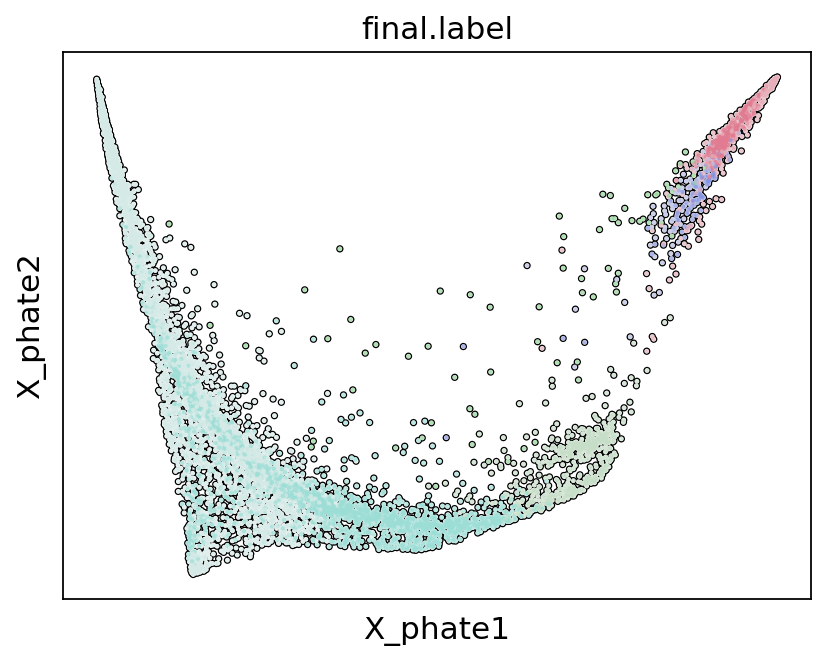

In [23]:
%matplotlib inline
p = sc.pl.embedding(adata, 
                basis='X_phate',
                color='final.label',
                palette=palette,
                return_fig=True,
                size=15,
                legend_loc=None,
                add_outline=True)

p.savefig('figures/phate.png', dpi=600)
p.savefig('figures/phate.pdf')

### h

In [2]:
import scanpy as sc
import pandas as pd
import numpy as np

from scanpy.plotting._anndata import _prepare_dataframe

In [7]:
adata = sc.read_h5ad('RNA.processed.h5ad', backed=True)

In [11]:
pss = pd.read_csv('perturbations/KO.PerturbationScores.csv', index_col=0)
pss[pss['group']=='Neu E']

group      score     gene
13    Neu E  24.138731   ARID3A
46    Neu E   0.840105   ARID5B
79    Neu E   3.422115      ARX
112   Neu E  20.061606    ASCL1
145   Neu E   5.641964     ATF3
...     ...        ...      ...
5260  Neu E   5.680665     ZIC5
5293  Neu E   2.173655  ZKSCAN4
5326  Neu E   6.031237   ZNF331
5359  Neu E  10.046938   ZNF667
5392  Neu E   2.016415   ZNF713

[164 rows x 3 columns]

In [8]:
pss = pd.read_csv('perturbations/KO.PerturbationScores.csv', index_col=0)
pss['log1p.score'] = np.log1p(pss['score'])
pss['rel_max.log1p.score'] = pss['log1p.score'] / pss.groupby('group')['log1p.score'].transform(np.max)
pss['q90'] = pss.groupby('group')['log1p.score'].transform(lambda x: x >= x.quantile(0.9))
all_genes = pss.gene.unique()
q90_genes = pss.gene[pss['q90']].unique()
q90_dict = pss[pss.q90].groupby('group')['gene'].unique().to_dict()
ct_q90_dict = {k:v  for k, v in q90_dict.items() if k in adata.obs['final.label'].cat.categories}
lin_q90_dict = {k:v  for k, v in q90_dict.items() if not k in adata.obs['final.label'].cat.categories and not 'not_' in k}

Storing dendrogram info using `.uns['dendrogram_final.label']`


/users/genomics/xoel/venvs/co_0.12/lib/python3.8/site-packages/scanpy/plotting/_dotplot.py:749: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


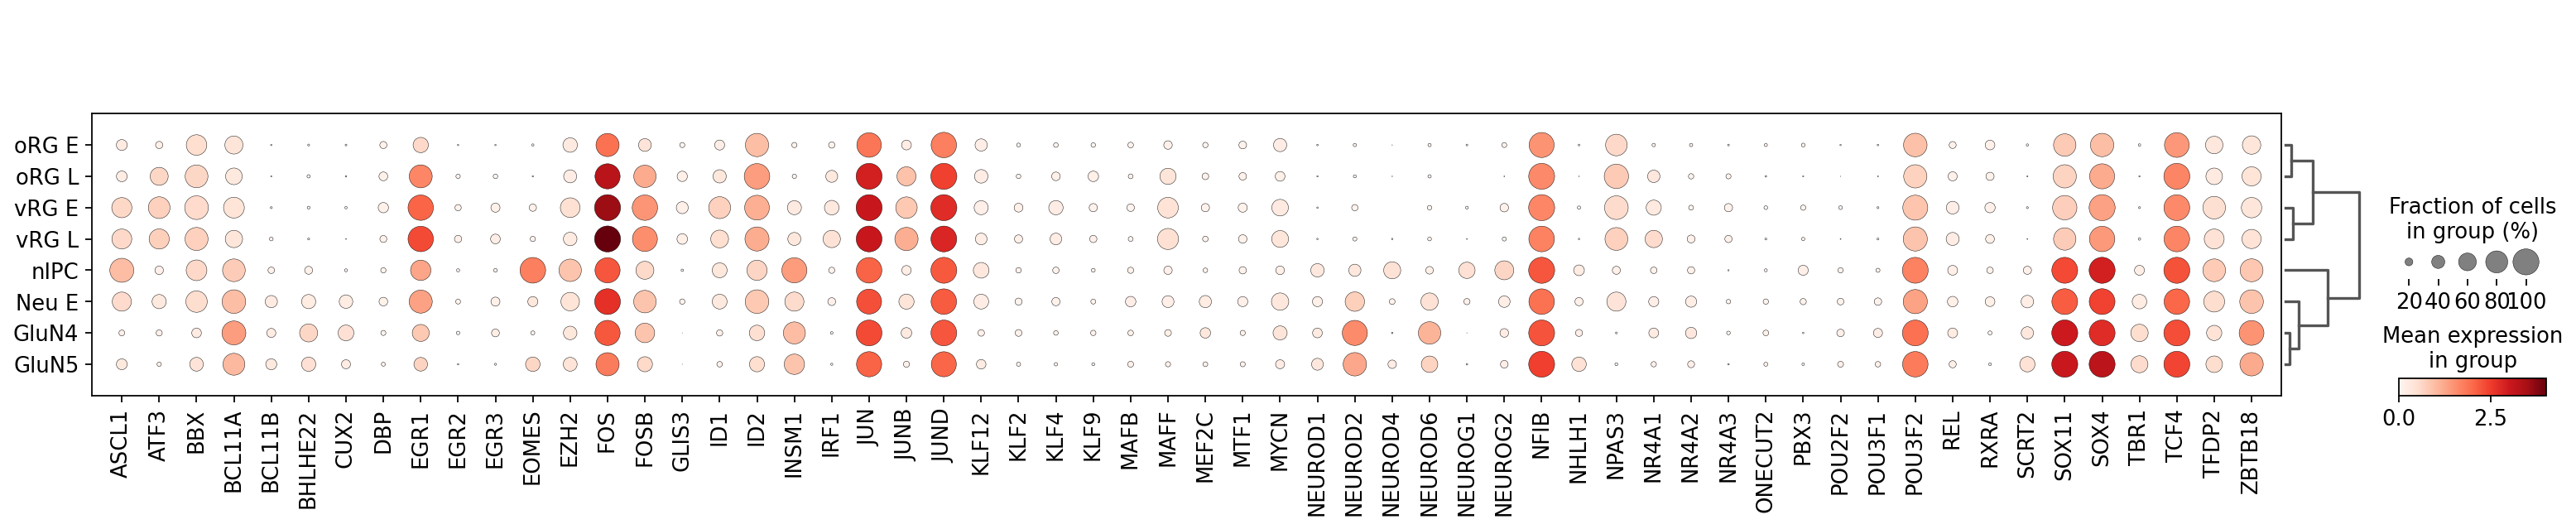

In [9]:
%matplotlib inline

sc.tl.dendrogram(adata, groupby='final.label', var_names=q90_genes)

sc.pl.dotplot(adata, q90_genes, 'final.label', layer='log1p', dendrogram=True)
# dp.add_totals().style(dot_edge_color='black', dot_edge_lw=0.5).show()

In [14]:
sel = ['RGC', 'nIPC', 'GluN']
q90_sel = { k: v for k, v in q90_dict.items() if k in sel}

/users/genomics/xoel/venvs/co_0.12/lib/python3.8/site-packages/scanpy/plotting/_dotplot.py:749: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


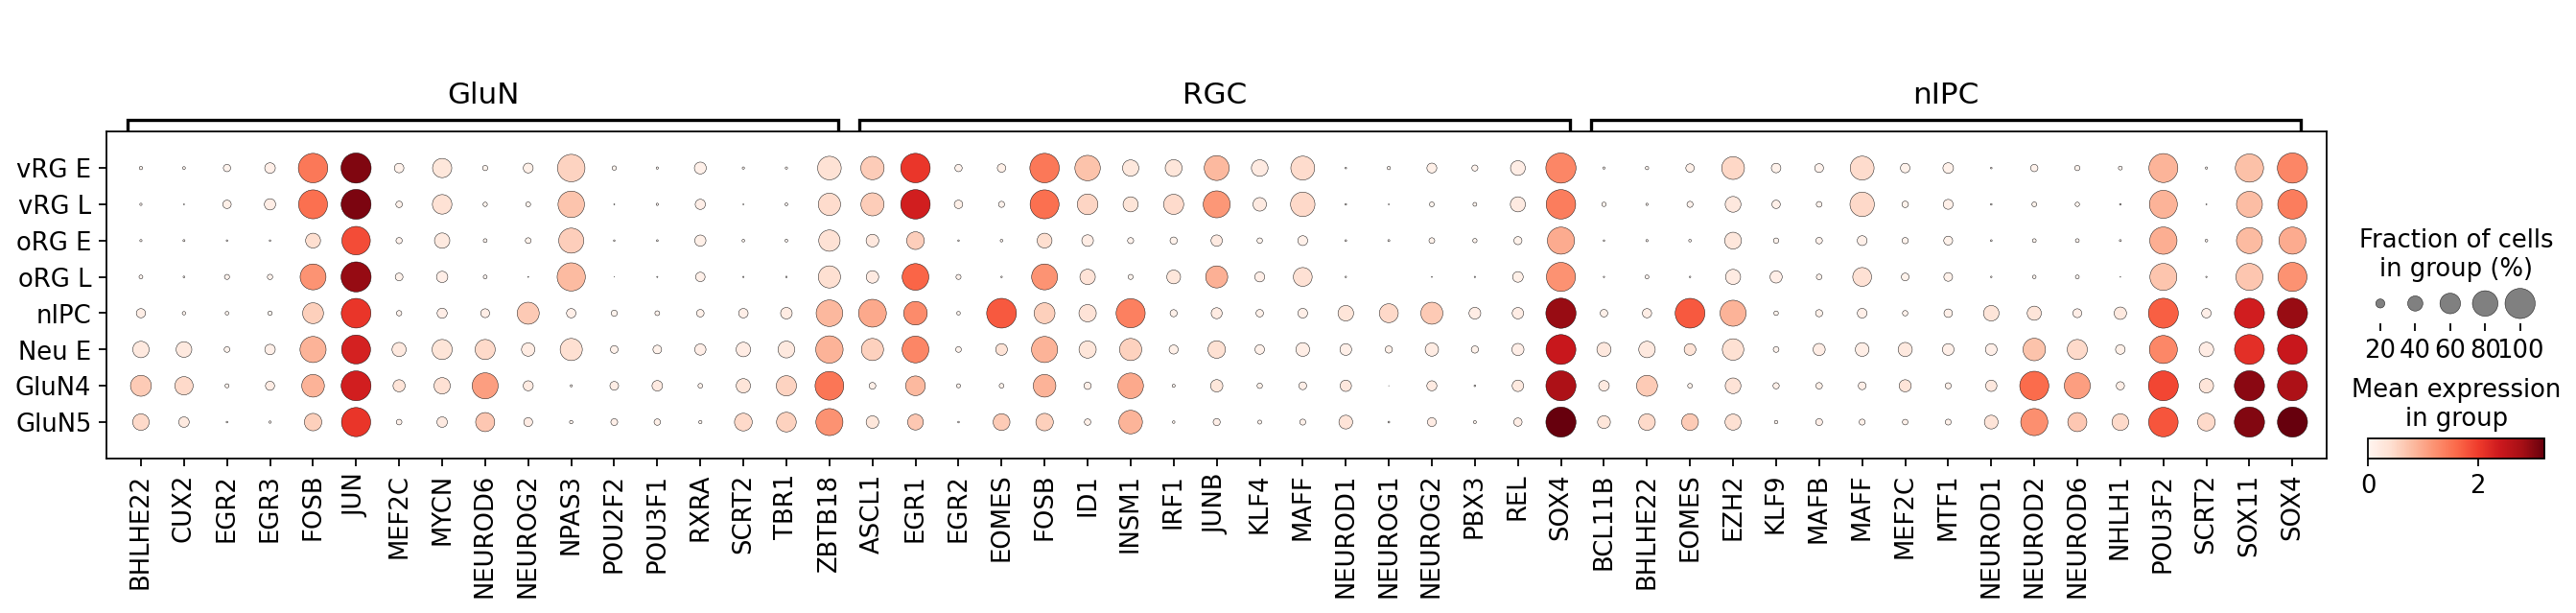

In [17]:
sc.pl.dotplot(adata, q90_sel, 'final.label', dendrogram=False, layer='log1p')

In [61]:
sizes = (_prepare_dataframe(adata, var_names=all_genes, groupby='final.label', use_raw=True, log=False)[1]>0).groupby('final.label').mean().T

exps = _prepare_dataframe(adata, var_names=all_genes, groupby='final.label', use_raw=False, layer='log1p', log=False)[1].groupby('final.label').mean().T

for k in lin_q90_dict.keys():

     if k != 'Whole data':
        a = adata[adata.obs['final.label'].isin(groups[k]), all_genes]
        mean = _prepare_dataframe(adata, var_names=all_genes, groupby='final.label', use_raw=False, layer='log1p', log=False)[1].mean().T
        pct = (_prepare_dataframe(a, var_names=all_genes, groupby='final.label', use_raw=True, log=False)[1]>0).mean()
        exps[k] = mean
        sizes[k] = pct

In [66]:
exps.to_csv('perturbations/KO.PerturbationScoreExpression.csv', index=True)
sizes.to_csv('perturbations/KO.PerturbationScoreExpressionPct.csv', index=True)